In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
from numba import njit
from scipy import odr
from scipy.special import voigt_profile
from scipy.optimize import curve_fit
from scipy import stats as st
import time
import warnings

os.chdir('F:/LANL/')
# os.chdir('/mnt/c/Users/gabeo/Desktop/analysis_temp/')
root = os.getcwd()

processedfolder = '/processed_data/'
vconstantsavename = root+processedfolder+'2_vparams_Tb'  ## MAKE SURE TARGET IS CORRECT !

search_arr = sorted(os.listdir(root + processedfolder))
print('Searhing in array (sorted): ', search_arr)
# print(search_arr[0])
folders_start = 'runs'+'13852-14191'
folders_end = 'runs'+'14500-15106'
# print(folders_start)
start_i = search_arr.index(folders_start)
end_i = search_arr.index(folders_end)
print('Indices in above array, starti-endi:', start_i,'-', end_i)
# print(end_i)
# print(len(search_arr[start_i:end_i+1]))

folderslist = []
if folders_start == folders_end:
    currfolder = search_arr[start_i]+'/'
    folderslist.append(currfolder)
else:
    for f in range(start_i, end_i+1):
#         print(f)
#         print(search_arr[f])
        currfolder = root+processedfolder+search_arr[f]
        currfolder = search_arr[f]+'/'
        print(currfolder)
        folderslist.append(currfolder)
#     runslist_D[f] = sorted(os.listdir(root+processedfolder+folders_start+'/asym_D'))
#     runslist_U[f] = sorted(os.listdir(root+processedfolder+folders_start+'/asym_U'))

numfolders = len(folderslist)
print(numfolders, 'folders, array of folders is: ', folderslist)

## change below to multiple folders?
runslist_D = []  ## array of runfolders, runs
runslist_U = []
for i in range(len(folderslist)):
    runslist_D.append(sorted(os.listdir(root+processedfolder+folderslist[i]+'/pulseadd_D')))
    runslist_U.append(sorted(os.listdir(root+processedfolder+folderslist[i]+'/pulseadd_U')))
# runslist_D = sorted(os.listdir(root+processedfolder+folders_start+'/ONOFF_D')) ## has to be changed to an array
# runslist_U = sorted(os.listdir(root+processedfolder+folders_start+'/ONOFF_U'))
# runslist_D =np.asarray(runslist_D)
# runslist_U =np.asarray(runslist_U)
# print(len(runslist_D))
# print(len(runslist_D[0]))
# print(len(runslist_D[1]))
## now flatten list so that all runs are in one array ## not sure I will use this
flatrunslist_D = [run for folder in runslist_D for run in folder]
flatrunslist_D = np.asarray(flatrunslist_D)
flatrunslist_U = [run for folder in runslist_U for run in folder]
flatrunslist_U = np.asarray(flatrunslist_U)
# print(len(flatrunslist_D))

numruns_tot_D = len(flatrunslist_D) ## U and D should be the same? ## should change to num pulses maybe
numruns_tot_U = len(flatrunslist_U) ## 
if numruns_tot_D != numruns_tot_U:
    warnings.warn('Number of Down runs =/= number of Up runs!')
else:
    print(f'downstream runs:{numruns_tot_D}, upstream:{numruns_tot_U}')


Searhing in array (sorted):  ['0_vparams_La.h5', '1_vparams_Pr.h5', 'La_sample', '_temp_xs.npy', 'runs07862-08069', 'runs09919-10159', 'runs11121-11138', 'runs11139-11412', 'runs11413-11726', 'runs11727-12033', 'runs12034-12363', 'runs12364-12684', 'runs12686-13279', 'runs13280-13563', 'runs13564-13604', 'runs13605-13735', 'runs13736-13851', 'runs13852-14191', 'runs14192-14499', 'runs14500-15106', 'runs15114-15568', 'runs15569-16110', 'runs16135-16392', 'runs16453-16763', 'runs88888-99999', 'xs_cut.npy', 'xs_uncut.npy']
Indices in above array, starti-endi: 17 - 19
runs13852-14191/
runs14192-14499/
runs14500-15106/
3 folders, array of folders is:  ['runs13852-14191/', 'runs14192-14499/', 'runs14500-15106/']
downstream runs:1240, upstream:1240


In [2]:
plt.rcParams.update({
    'axes.titlesize': 'xx-large',
    'axes.labelsize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large',
    'xtick.minor.visible': 'True',
    'ytick.minor.visible': 'True',
    'axes.grid': 'True',
    'axes.grid.which': 'both',
    'grid.alpha': '0.5',
    'grid.linestyle': ':',
    'legend.fontsize': 'medium',
    'figure.figsize': '10.0, 7.0',
    'backend': 'Qt5agg',
    'interactive': 'True',
    'figure.autolayout': 'True',
    'lines.linewidth': '1.7',
})
# %matplotlib qt
print('updated rcparam')

updated rcparam


# Need to get num pulses!!! ending runs dont have as many pulses !!

In [3]:
## load in the x array. Also helps in determining sizes
channels_all = []
folderpath = root+processedfolder+folderslist[0]
with h5py.File(folderpath+'/pulseadd_D/'+runslist_D[0][0], 'r') as f: ## new arr_sizer
    channels_D = list(f.keys())
    channels_all.append(channels_D[:-2])
    numchannels = len(channels_D)-1
    dataset = f[channels_D[-1]]   ## this is the xs dataset
    xs = np.array(dataset)*1e-6 ## now in ms
    numpoints = len(xs)
    f.close()
    
with h5py.File(folderpath+'/pulseadd_U/'+runslist_U[0][0], 'r') as f: ## new arr_sizer
    channels_U = list(f.keys())
    channels_all=np.append(channels_all, channels_U[:-1])
#     channels_all.append(channels[:-1])
    numchannels = len(channels_U)-1
    dataset = f[channels_U[-1]]   ## this is the xs dataset
    xs = np.array(dataset)*1e-6 ## now in ms
    numpoints = len(xs)
    f.close()
# print(channels_all)
# channels_all = np.asarray(channels_all, dtype=object)
# print(channels_all)
# channels_all = channels_all.flatten()
print(numruns_tot_D,numchannels,numpoints)
# print(data.shape)
# print(data[seq][0][0])
print(channels_all[:])
print(channels_all[-1])
print(len(xs))
print(channels_D)
print(channels_U)

print(channels_all)

# print(channels_all.flatten())
# print(data)

1240 13 8992
['ch_00' 'ch_01' 'ch_02' 'ch_03' 'ch_04' 'ch_05' 'ch_06' 'ch_07' 'ch_08'
 'ch_09' 'ch_10' 'ch_11' 'ch_12' 'ch_13' 'ch_14' 'ch_15' 'ch_16' 'ch_17'
 'ch_18' 'ch_19' 'ch_20' 'ch_21' 'ch_22' 'ch_23' 'ch_24']
ch_24
8992
['ch_00', 'ch_01', 'ch_02', 'ch_03', 'ch_04', 'ch_05', 'ch_06', 'ch_07', 'ch_08', 'ch_09', 'ch_10', 'ch_11', 'ch_24', 'xs ']
['ch_12', 'ch_13', 'ch_14', 'ch_15', 'ch_16', 'ch_17', 'ch_18', 'ch_19', 'ch_20', 'ch_21', 'ch_22', 'ch_23', 'ch_24', 'xs ']
['ch_00' 'ch_01' 'ch_02' 'ch_03' 'ch_04' 'ch_05' 'ch_06' 'ch_07' 'ch_08'
 'ch_09' 'ch_10' 'ch_11' 'ch_12' 'ch_13' 'ch_14' 'ch_15' 'ch_16' 'ch_17'
 'ch_18' 'ch_19' 'ch_20' 'ch_21' 'ch_22' 'ch_23' 'ch_24']


In [4]:
print(channels_all[13])
# print(runslist_D)
print(len(folderslist))
print(len(runslist_D[1]))
print(runslist_D[1][0])

ch_13
3
306
14192_pulseadd_D.h5


In [5]:
def loadrun_pulseadd(run, processedpath): ## not sure if this is the fastest way, or passing a list of runs...
    runname = processedpath+run
    with h5py.File(runname, 'r') as f:
        channels = list(f.keys())
        numchannels = len(channels)-1
        arrsizer = f[channels[-1]] ## gets the xs array
        arrsizer = np.asarray(arrsizer)
        numpoints = len(arrsizer)
        rundat = np.zeros((numchannels,numpoints),dtype = np.float64)
#             print(str(np.char.zfill(str(chan_enab[i]),2)))
#             dataset = f['ch '+str(np.char.zfill(str(chan_enab[i]), 2))]
        for i in range(0,numchannels):
            dataset = f[channels[i]+'/added_pulses/'+channels[i]][:]  ##change this to match channels[i]
            chdata = np.array(dataset)
            rundat[i] = rundat[i]+chdata
        f.close()
    return rundat

In [6]:
start=time.time()
# all_D = [] ## in this case cannot be np array because it is not same size arrays ## will be run, channel, numpoints
# all_D = np.zeros((numruns_tot_D, numchannels,numpoints),dtype = np.float64) ## run, channel, numpoints ## works if flatten the folders
# all_U = np.zeros((numruns_tot_U, numchannels,numpoints),dtype = np.float64) ## run, channel, numpoints ## works if flatten the folders
all_D = []
all_U = []

for f in range(0,len(folderslist)):
    fpath = root+processedfolder+folderslist[f]
    for r in range(0, len(runslist_D[f])):
#         print(runslist_D[f][r])
#         all_D.append(loadrun_pulseadd(runslist_D[f][r], fpath+'/pulseadd_D/'))
#         print(r)
#         all_D[r] = loadrun_pulseadd(runslist_D[f][r], fpath+'/pulseadd_D/')
#         all_U[r] = loadrun_pulseadd(runslist_U[f][r], fpath+'/pulseadd_U/')
        all_D.append(loadrun_pulseadd(runslist_D[f][r], fpath+'/pulseadd_D/'))
        all_U.append(loadrun_pulseadd(runslist_U[f][r], fpath+'/pulseadd_U/'))
#         print(all_D[r])
    print(fpath+' done')

all_D = np.asarray(all_D)
all_U = np.asarray(all_U)
## don't do below yet, rest of program assumes run, ch
# all_D = all_D.transpose(1, 0, 2) ## change from [run, ch, numsamples] to [ch, run, numsamples] !!!!
# all_U = all_U.transpose(1, 0, 2)
    
end=time.time()
print('loaded files time: ', end-start)

F:\LANL/processed_data/runs13852-14191/ done
F:\LANL/processed_data/runs14192-14499/ done
F:\LANL/processed_data/runs14500-15106/ done
loaded files time:  9.35605525970459


(1240, 13, 8992)
(13, 1240, 8992)


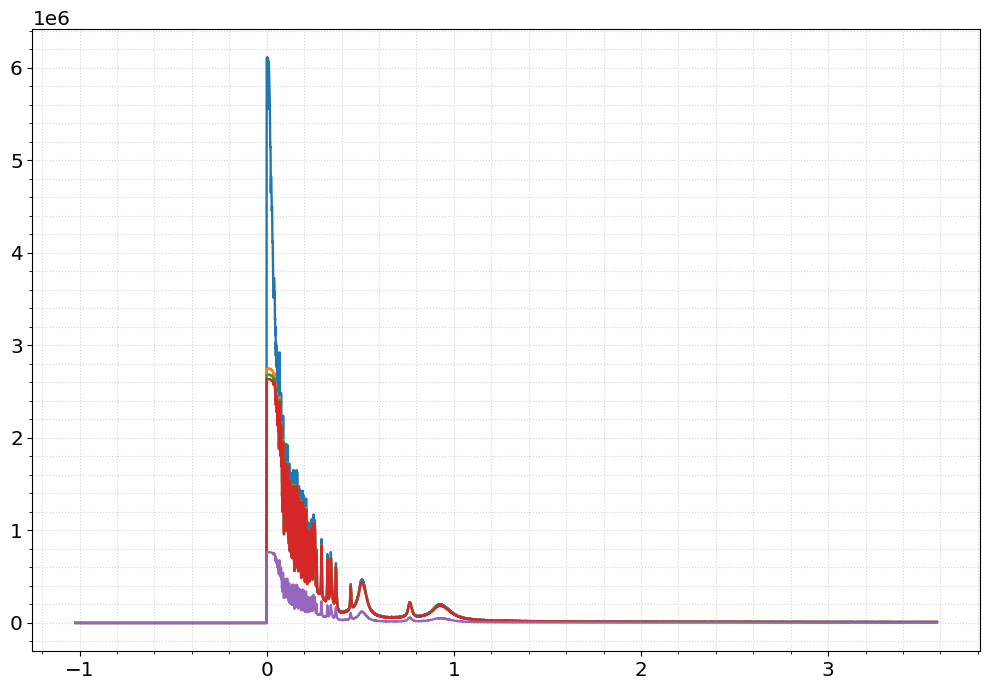

In [7]:
%matplotlib inline
plt.plot(xs, all_U[0][1])
plt.plot(xs, all_U[150][1])
plt.plot(xs, all_U[200][1])
plt.plot(xs, all_U[350][1])
# plt.plot(xs, all_U[500][1])
plt.plot(xs, all_U[-1][1])
print(all_U.shape)

test_reshape = all_U.transpose(1, 0, 2) ## switches first array to channels and second array to pulses
print(test_reshape.shape)

In [8]:
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                         all_D:  1.1 GiB
                         all_U:  1.1 GiB
                flatrunslist_D: 92.1 KiB
                flatrunslist_U: 92.1 KiB
                            xs: 70.4 KiB
                           _i1:  2.9 KiB
                           _ii:  1.4 KiB
                           _i6:  1.4 KiB
                           _i3:  1.3 KiB
                          _iii:  889.0 B


In [9]:
## makes a total spectra out of all runs. Second version w function.
def spectra_maker(allarray_DU):  ## make sure array is Downstream _D then Upstream _U!!!
    addtimes=0
    if len(allarray_DU[0])!=len(allarray_DU[1]):
        emessage = 'Error: different num of down and up runs'
        raise Exception(emessage)
    allDarr = allarray_DU[0]
    allUarr = allarray_DU[1]
    # print(allDarr.shape)
    spectra_D = np.zeros((numchannels,numpoints), dtype = np.float64) 
    spectra_U = np.zeros((numchannels,numpoints), dtype = np.float64)
    print(f'number of runs: {len(allDarr)}')
    printruns = np.linspace(len(allDarr)//5, len(allDarr), 5, dtype=int)
    for r in range(0, len(allDarr)): ## for every run
        # print(r)
        start = time.time()
        full = len(allDarr)
        if r == round(full/5) or r == round(2*full/5) or r == round(3*full/5) or r == round(4*full/5) or r == full-1:
        # if r ==printruns[0]  or r==printruns[1] or r==printruns[2] or r==printruns[3] or r==printruns[4]:
            print(rf'to run {r} took another {addtimes}')
            addtimes=0
        for ch in range(0, numchannels): ## and every channel
    #         if channels_D[ch] == 'ch_24':
    #             emessage = ('bg_ fit does not work for 6Li yet')
    #             print(emessage)
    #             logger.error('run '+run_num + emessage)
    #             raise Exception(emessage)
            # print(r, ch)
    #         print(channels[ch])
    #         print(len(bgsub_D[r][ch]))
    #         print(len(all_D[r][ch]))
            spectra_D[ch] = spectra_D[ch]+allDarr[r][ch]
            spectra_U[ch] = spectra_U[ch]+allUarr[r][ch]
        end = time.time()
        addtimes = addtimes+(end-start)
    return spectra_D, spectra_U

12
Tb
number of runs: 1240
to run 248 took another 0.04529261589050293
to run 496 took another 0.04590916633605957
to run 744 took another 0.04899001121520996
to run 992 took another 0.053928375244140625
to run 1239 took another 0.05177497863769531
(13, 8992) 

(25, 8992) 



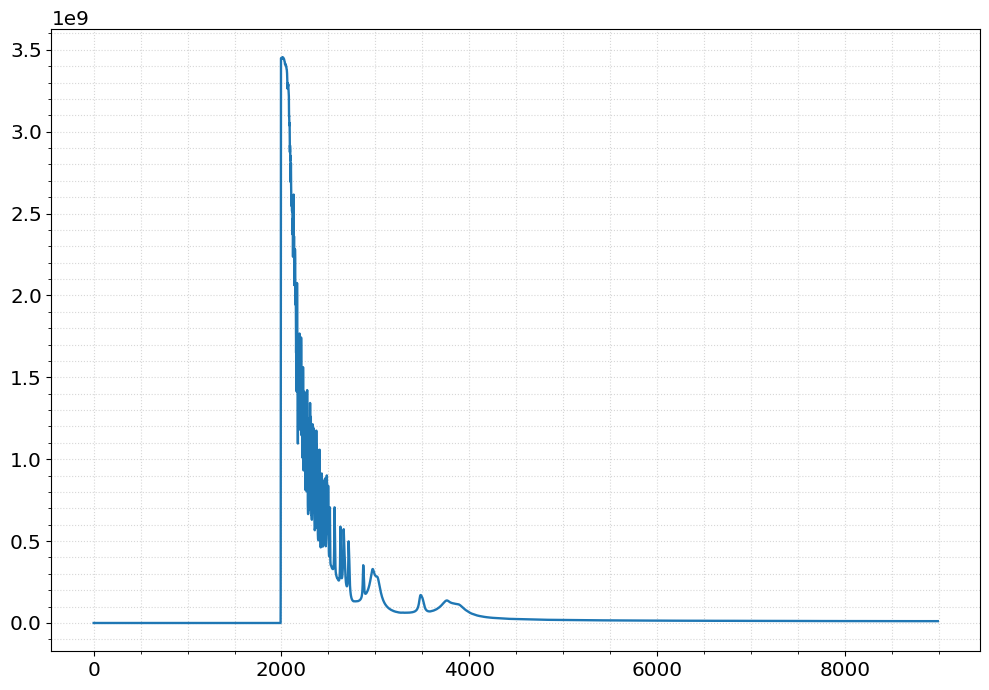

In [10]:
## add up all pulses to look at a nice spectra
start = time.time()

if numchannels != 13:
    emessage = 'numchannels does not have 6Li'
    raise Exception(emessage)
num_fittingchs = numchannels-1  ## removes the Li detector, assumes it is there
print(num_fittingchs)

print('Tb')
spectra_D, spectra_U = spectra_maker([all_D, all_U])
print(spectra_D.shape, '\n')
spectra = np.vstack((spectra_D[:-1], spectra_U)) ## combine up- and down-stream
print(spectra.shape, '\n')
plt.plot(spectra[1])

In [11]:
##rebinning functions

from functools import reduce
def factors(n):
    return np.sort(np.array((reduce(list.__add__,([i, n//i] for i in range(1, int(n**0.5) + 1) if n % i == 0)))))

def rebin(ys, xs, rebinfactor):
    outys = ys.reshape(-1, rebinfactor).mean(axis=1)
    outxs = xs.reshape(-1, rebinfactor).mean(axis=1)
    return outys, outxs

y = all_U[1][1]
print(len(y))
rebinfactors = np.sort(np.array(list(factors(len(y)))))
print(f'possible factors are ', rebinfactors)

rebinf = rebinfactors[3]
print(f'using factor {rebinf}')

8992
possible factors are  [   1    2    4    8   16   32  281  562 1124 2248 4496 8992]
using factor 8


##### looks like some of the runs for Tb do not have a clear resonance. Add them up?

In [12]:
print(f'U run factors: {factors(numruns_tot_U)} \nD run factors: {factors(numruns_tot_U)}')
runrefaci = 6
runrefactor = factors(numruns_tot_U)[runrefaci]
print(f'Refactor {numruns_tot_U} runs in sets of {runrefactor} in to {int(numruns_tot_U/runrefactor)} runs')

U run factors: [   1    2    4    5    8   10   20   31   40   62  124  155  248  310
  620 1240] 
D run factors: [   1    2    4    5    8   10   20   31   40   62  124  155  248  310
  620 1240]
Refactor 1240 runs in sets of 20 in to 62 runs


In [13]:
import io
from contextlib import redirect_stdout

In [14]:
## add up all pulses to look at a nice spectra
start = time.time()

if numchannels != 13:
    emessage = 'numchannels does not have 6Li'
    raise Exception(emessage)
num_fittingchs = numchannels-1  ## removes the Li detector, assumes it is there
print(num_fittingchs)

print('Tb')

spectra_runrebin_D = []
spectra_runrebin_U = []
for i in range(int(numruns_tot_U/runrefactor)): ## refactored into this many total runs
    # print(i*runrefactor,(i+1)*runrefactor)
    f = io.StringIO() # Create a dummy stream to redirect output to
    with redirect_stdout(f): # Use redirect_stdout to suppress printing    
        spectra_runrebin_D_temp, spectra_runrebin_U_temp = spectra_maker([all_D[i*runrefactor:(i+1)*runrefactor], all_U[i*runrefactor:(i+1)*runrefactor]])
    spectra_runrebin_D.append(spectra_runrebin_D_temp)
    spectra_runrebin_U.append(spectra_runrebin_U_temp)
del spectra_runrebin_D_temp, spectra_runrebin_U_temp
spectra_runrebin_D, spectra_runrebin_U = np.array(spectra_runrebin_D), np.array(spectra_runrebin_U)

print(f'New D/U run shapes: {spectra_runrebin_D.shape}, {spectra_runrebin_U.shape}')

## this reshapes array, but background and voigt fits are done by run. So don't need yet
# spectra_runrebin_D = np.asarray(spectra_runrebin_D.transpose(1,0,2))  ## re-shape into ch, run, points
# spectra_runrebin_U = np.asarray(spectra_runrebin_U.transpose(1,0,2))  ## re-shape into ch, run, points
# print(f'changed to: {spectra_runrebin_D.shape}, {spectra_runrebin_U.shape}')
# spectra_runrebin = np.vstack((spectra_runrebin_D[:-1], spectra_runrebin_U)) ## combine up- and down-stream
# print(f'stacked: {spectra_runrebin.shape}')
# print(all_D.shape)

12
Tb
New D/U run shapes: (62, 13, 8992), (62, 13, 8992)


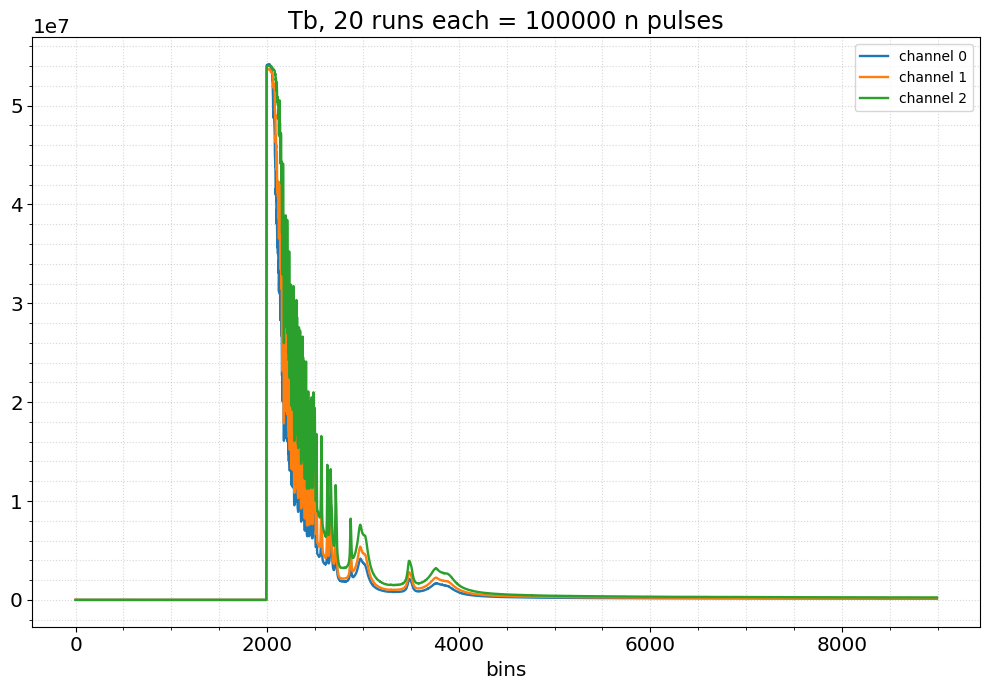

In [15]:
ch =1
r = 10
# print(spectra_U_smalltest1.shape)
for ch in range(3):
    plt.plot(spectra_runrebin_D[r][ch], label=f'channel {ch}')

plt.title(f'Tb, {runrefactor} runs each = {runrefactor*5000} n pulses')
plt.xlabel('bins')
plt.legend()

In [16]:
%matplotlib qt
ch = 1
r = 1
ch_U_rebin, xs_rebin = rebin(all_U[ch][r], xs, rebinf)
# print(len(spectra_pos), len(spectra_rebin))

plt.plot(xs, all_U[ch][r], label = 'normal')
plt.plot(xs_rebin, ch_U_rebin, label = 'rebinned', ls = '--')
plt.title(f'testing rebin')
plt.ylabel('counts [arb]',fontsize = 'x-large')
plt.xlabel('tof',fontsize = 'x-large')
plt.ylim(3000,25000)
plt.xlim(1.5,3.0)
plt.legend()
plt.show()

In [17]:
m_n = 1.6749286*10**(-27)
# L = 0
J_to_eV = 6.24151*10**18
eV_to_J = 1.602176565*10**-19

def tof_to_eV(xtof, FPlength, t_off):
    m_n = 1.6749286*10**(-27)
    delay = t_off
    x_eV_out = 0.5*m_n*((FPlength/((xtof+delay)/1000)))**2*J_to_eV  ## tof in ms
    return x_eV_out
def eV_to_tof(xeV, FPlength, t_off):
    m_n = 1.6749286*10**(-27)
    delay = t_off
    x_tof_out = delay + 1000*FPlength*np.sqrt(m_n/(2*xeV*eV_to_J))  ## tof in ms
    return x_tof_out

In [18]:
# fpl = 23.497
fpl = 23.31
zeropoint = np.where(xs>=0)[0][0]
daq_delay = 0
print(zeropoint)
xpos = xs[zeropoint:]
x_eV = tof_to_eV(xpos, fpl, daq_delay)
spectra_pos = spectra[:,zeropoint:]

plt.loglog(x_eV, spectra_pos[ch], label=f'ch {ch}')
plt.title(f'testing to eV conversion, with fpl {fpl}')
plt.ylabel('counts [arb]',fontsize = 'x-large')
plt.xlabel('eV',fontsize = 'x-large')
lineeV = 6.46
plt.axvline(x = lineeV,ls = '--', c = 'r', label=f'line at {lineeV} eV')
# plt.ylim(3000,14000)
# plt.xlim(1.5,3.0)
plt.legend()
plt.show()

1996


C:\Users\gabeo\AppData\Local\Temp\ipykernel_29424\2271629283.py:9: RuntimeWarning: divide by zero encountered in divide
  x_eV_out = 0.5*m_n*((FPlength/((xtof+delay)/1000)))**2*J_to_eV  ## tof in ms


## using pulseadd to find best values for voigt fits. Get fit values for every run (to get a distribution of x_loc, sig, gam

In [19]:
# %matplotlib inline
# temp_rebin_y, temp_rebin_x = rebin(y, xs, rebinf)
# # plt.plot(temp_rebin_x, temp_rebin_y)
# # plt.show()
# # xs_E = 3.895662*10**(-6)*(1/(xs[2001:]/1000)**2)

# h = 6.62607015e-34  ## joule-seconds
# m = 1.67492749804e-27 ## kg
# eV_to_J = 1.602176565e-19 ## conversion factor
# m_to_A = 1e10 ## m to Angstrom converstion factor

# x_tof = xs
# fpl = 23.46 ## flight path length estimate
# t_to_eV_test = 0.5*(1.6749286*10**(-27))*((fpl/(x_tof/1000)))**2*(6.24151*10**18) ##*1000 seems to work

# plt.plot(t_to_eV_test[2800:], all_U[1][1][2800:])
# plt.show()

###### poly fit fncs try with chat gpt lol

In [20]:
@njit
def polyN_fit_errors(x, y, degree):
    """Fit y = a0*x^n + a1*x^(n-1) + ... + an using least squares and return errors.
Parameters:
        x : 1D array of inputs
        y : 1D array of outputs
        degree : int, degree of polynomial
Returns:
        coeffs : array of fitted coefficients [a0, a1, ..., an]
        stderr : array of standard errors (1-sigma) for each coefficient"""
    n = x.shape[0]
    A = np.empty((n, degree + 1))
    for i in range(n):
        xi = x[i]
        A[i, degree] = 1.0
        for j in range(degree - 1, -1, -1):
            A[i, j] = A[i, j + 1] * xi

    ATA = A.T @ A
    ATy = A.T @ y
    coeffs = np.linalg.solve(ATA, ATy)

    # Calculate residuals and variance
    y_fit = A @ coeffs
    residuals = y - y_fit
    dof = n - (degree + 1)
    residual_variance = np.sum(residuals**2) / dof

    # Covariance matrix and standard errors
    cov_matrix = np.linalg.inv(ATA) * residual_variance
    stderr = np.sqrt(np.diag(cov_matrix))

    return coeffs, stderr

def polyN_predict(x, coeffs):
    """Evaluate polynomial at x using Horner's method.
Parameters:
        x : 1D array of input data
        coeffs : 1D array of coefficients [a0, a1, ..., an]
Returns:
        y : predicted values"""
    n = x.shape[0]
    y = np.empty(n)
    degree = coeffs.shape[0]
    for i in range(n):
        xi = x[i]
        yi = coeffs[0]
        for j in range(1, degree):
            yi = yi * xi + coeffs[j]
        y[i] = yi
    return y

# @njit  ### this doesn't work right now
# def polyN_residuals(x, y, coeffs):
#     """
#     Compute residuals y - y_fit.
#     """
#     y_fit = polyN_predict(x, coeffs)
#     return y - y_fit

In [26]:
## try the function to also output reduced chi square for determining goodness of fit

@njit
def polyN_fit_chi2(x, y, degree):
    """
    Fit a polynomial of given degree to (x, y) using least squares.

    Returns:
        coeffs : fitted polynomial coefficients [a0, a1, ..., an]
        stderr : standard errors (1-sigma) of the coefficients
        red_chi2 : reduced chi-squared (chi2 / dof), assumes sigma_i = 1
    """
    n = x.shape[0]
    A = np.empty((n, degree + 1))
    for i in range(n):
        xi = x[i]
        A[i, degree] = 1.0
        for j in range(degree - 1, -1, -1):
            A[i, j] = A[i, j + 1] * xi

    ATA = A.T @ A
    ATy = A.T @ y
    coeffs = np.linalg.solve(ATA, ATy)

    # Predicted values and residuals
    y_fit = A @ coeffs
    residuals = y - y_fit

    dof = n - (degree + 1)
#     dof=1
    chi2 = np.sum(residuals**2)
    red_chi2 = chi2 / dof

    cov_matrix = np.linalg.inv(ATA) * red_chi2
    stderr = np.sqrt(np.diag(cov_matrix))

    return coeffs, stderr, red_chi2

@njit
def polyN_fit_chi2_w(x, y, sigma, degree):
    """
    Weighted least squares polynomial fit of any degree.

    Parameters:
        x : 1D array of input data
        y : 1D array of target data
        sigma : 1D array of standard deviation (uncertainty) of each y
        degree : degree of the polynomial

    Returns:
        coeffs : polynomial coefficients [a0, a1, ..., an]
        stderr : standard error (1-sigma) of each coefficient
        red_chi2 : reduced chi-squared of the fit
    """
    n = x.shape[0]
    A = np.empty((n, degree + 1))
    for i in range(n):
        xi = x[i]
        A[i, degree] = 1.0
        for j in range(degree - 1, -1, -1):
            A[i, j] = A[i, j + 1] * xi

    # Apply weights: divide rows by sigma
    for i in range(n):
        for j in range(degree + 1):
            A[i, j] /= sigma[i]

    y_weighted = y / sigma

    ATA = A.T @ A
    ATy = A.T @ y_weighted
    coeffs = np.linalg.solve(ATA, ATy)

    # Residuals and reduced chi-squared
    y_fit = A @ coeffs
    residuals = y_weighted - y_fit
    chi2 = np.sum(residuals**2)
    dof = n - (degree + 1)
    red_chi2 = chi2 / dof

    cov_matrix = np.linalg.inv(ATA) * red_chi2
    stderr = np.sqrt(np.diag(cov_matrix))

    return coeffs, stderr, red_chi2

def polyN_fit_chi2_w2(x, y, sigma, degree):
    """
    Weighted least squares polynomial fit of any degree.
    
    Returns:
        coeffs : polynomial coefficients
        stderr : 1-sigma error for each coefficient
        red_chi2 : reduced chi-squared
        residuals : y - y_fit (unweighted)
    """
    n = x.shape[0]
    A = np.empty((n, degree + 1))
    for i in range(n):
        xi = x[i]
        A[i, degree] = 1.0
        for j in range(degree - 1, -1, -1):
            A[i, j] = A[i, j + 1] * xi

    # Apply weights
    for i in range(n):
        for j in range(degree + 1):
            A[i, j] /= sigma[i]
    y_weighted = y / sigma

    ATA = A.T @ A
    ATy = A.T @ y_weighted
    coeffs = np.linalg.solve(ATA, ATy)

    # Compute fitted values and residuals
    y_fit = A @ coeffs
    residuals = y_weighted - y_fit

    chi2 = np.sum(residuals**2)
    dof = n - (degree + 1)
#     dof=1
    red_chi2 = chi2 / dof

    cov_matrix = np.linalg.inv(ATA) * red_chi2
    stderr = np.sqrt(np.diag(cov_matrix))

    # Convert residuals back to original units
    res_unweighted = (y_weighted - y_fit) * sigma

    return coeffs, stderr, red_chi2, res_unweighted

### now select the background region around the resonance of interest

In [27]:
#### find bins of bg region

In [30]:
%matplotlib inline
plt.figure()

bg_region1_beg = 3225
bg_region1_end = 3270
bg_region2_beg = 3314
bg_region2_end = 3410
bg_reg1 = [bg_region1_beg,bg_region1_end]
bg_reg2 = [bg_region2_beg,bg_region2_end]
print(bg_reg1, bg_reg2)
fullrange = bg_reg2[1]-bg_reg1[0]
r = 40
ch = 2

start = time.time()
aft_res_reg = bg_reg2
bef_res_reg = bg_reg1

binstot = aft_res_reg[1]-bef_res_reg[0]  ## total number of bins in whole region
x1 = np.arange(bef_res_reg[0], bef_res_reg[1]+1,1)
x2 = np.arange(aft_res_reg[0], aft_res_reg[1]+1,1)
x = np.append(x1,x2)
print(x1[0], x1[-1])

fullx = np.arange(bef_res_reg[0], aft_res_reg[1],1) ## an array of every x bin in entire region
ys_bgsub = []

# ys = all_D[r][ch]
ys = spectra_runrebin_D[r][ch]

fitdata1 = ys[bef_res_reg[0]: bef_res_reg[1]+1]
fitdata2 = ys[aft_res_reg[0]: aft_res_reg[1]+1]
datasplice = np.append(fitdata1, fitdata2)
y = datasplice
linecolors = ['lies','g','r','c','m','y']
f = 1
width = 2

# plt.plot(ys, label = 'original', lw=width+0.5)
# # plt.plot(fullx, ys[bef_res_reg[0]: aft_res_reg[1]]/f, label='region o interest')
# plt.plot(x1, ys[x1[0]:x1[-1]+1]/f, label='1st polyfit region', ls = '--', lw=width-0.9)
# plt.plot(x2, ys[x2[0]:x2[-1]+1]/f, label='2nd polyfit region', ls = '--', lw=width-0.9)
# x_eV = tof_to_eV(xpos, fpl, daq_delay)
lineeV = 6.46
linetof = eV_to_tof(lineeV, fpl, daq_delay)
linebin = np.where((xs>=(linetof-0.001)) & (xs<=(linetof+0.001)))[0][0]
# print(linebin)
# plt.axvline(x = linebin,ls = '--', c = 'r', label=f'rough res loc., line at {lineeV} eV')
# plt.legend()
# plt.title(f'Resonance bin search')
# plt.ylabel('Counts [arb]',fontsize = 'x-large')
# plt.xlabel('Bin',fontsize = 'x-large')
# # plt.ylim(-5000, 600000)
# # plt.xlim(bg_region1_beg-200, bg_region2_end+200)
# plt.show()

[3225, 3270] [3314, 3410]
3225 3270


<Figure size 1000x700 with 0 Axes>

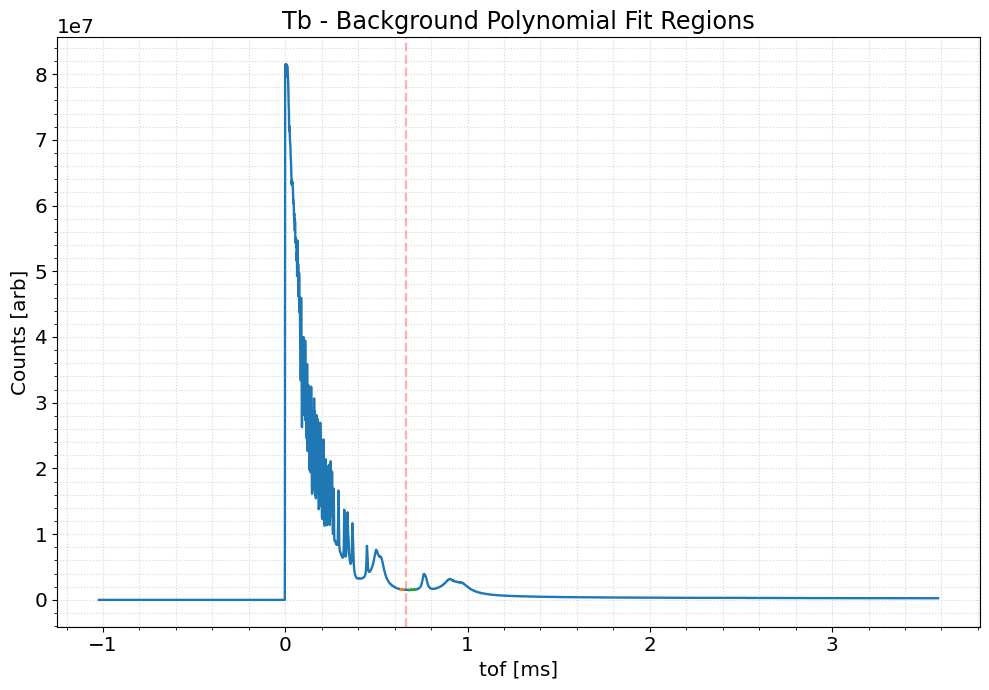

In [31]:
## redoing plot above for thesis
%matplotlib inline
fig, ax = plt.subplots()
ax.set(xlabel='tof [ms]', ylabel='Counts [arb]',title='Tb - Background Polynomial Fit Regions')

plt.plot(xs, ys, label = 'Measured')
# plt.plot(fullx, ys[bef_res_reg[0]: aft_res_reg[1]]/f, label='region o interest')
plt.plot(xs[x1], ys[x1[0]:x1[-1]+1]/f, label='1st polyfit region', ls = '--')
plt.plot(xs[x2], ys[x2[0]:x2[-1]+1]/f, label='2nd polyfit region', ls = '--')
plt.axvline(x = linetof, ls = '--', c = 'r',alpha = 0.30, label=f'Rough resonance loc., at {lineeV} eV')



# plt.tick_params(axis='x')
# plt.tick_params(axis='y', labelcolor = 'black')
# plt.ylim(0, 5.0)
    
# plt.grid(True, which='both',axis = 'both', alpha = 0.75, ls = ':')
# plt.minorticks_on()
# plt.xticks(fontsize = 'xx-large')
# plt.yticks(fontsize = 'x-small')
# plt.legend(loc="center left", bbox_to_anchor=(0.12, 0.45))
# plt.legend(fontsize = ls2)

# plt.legend(fontsize = 'medium')
plt.show()

In [32]:
# ## redoing plot above for thesis
# %matplotlib qt
# plt.figure()
# lw = 1.2
# ls1 = 'xx-large'
# ls2 = 'x-large'
# plt.tight_layout(rect=[0.125, 0.130, 0.875, 0.920])  ## left bottom right 

# plt.plot(xs, ys, label = 'Measured', lw=width+0.5)
# # plt.plot(fullx, ys[bef_res_reg[0]: aft_res_reg[1]]/f, label='region o interest')
# plt.plot(xs[x1], ys[x1[0]:x1[-1]+1]/f, label='1st polyfit region', ls = '--', lw=width-0.9)
# plt.plot(xs[x2], ys[x2[0]:x2[-1]+1]/f, label='2nd polyfit region', ls = '--', lw=width-0.9)
# plt.axvline(x = linetof, ls = '--', c = 'r',alpha = 0.30, label=f'Rough resonance loc., at {lineeV} eV')

# plt.ylabel('Counts [arb]', fontsize=ls1)
# plt.xlabel('tof [ms]', fontsize=ls1)
# plt.tick_params(axis='x', labelsize = ls2)
# plt.tick_params(axis='y', labelsize = ls2, labelcolor = 'black')
# # plt.ylim(0, 5.0)
# plt.title(r'Tb - Background Polynomial Fit Regions', fontsize = 'xx-large')

# plt.grid(True, which='both',axis = 'both', alpha = 0.75, ls = ':')
# plt.minorticks_on()
# # plt.xticks(fontsize = 'xx-large')
# # plt.yticks(fontsize = 'x-small')
# # plt.legend(loc="center left", bbox_to_anchor=(0.12, 0.45))
# plt.legend(fontsize = ls2)

# # plt.legend(fontsize = 'medium')
# plt.show()

In [33]:
print(eV_to_tof(4.24,fpl,0))

0.8184408713301381


In [34]:
print(y.shape)
print(fullx.shape)

(143,)
(185,)


In [35]:
ys_bgsub = []
# ys = all_D[r][ch]
ys = spectra_runrebin_D[r][ch]
fitdata1 = ys[bef_res_reg[0]: bef_res_reg[1]+1]
fitdata2 = ys[aft_res_reg[0]: aft_res_reg[1]+1]
datasplice = np.append(fitdata1, fitdata2)
y = datasplice

In [36]:
## plot different orders of polynomial
## Rerun cell above before re-running this one
%matplotlib qt
plt.figure()

linecolors = ['lies','g','r','c','m','y']
f = 10000
plotoffset = -120

plt.plot(fullx, ys[bef_res_reg[0]: aft_res_reg[1]]/f+plotoffset)
# rebinfactors = np.sort(np.array(list(factors(len(y)))))
rebinfactors = np.sort(np.array(list(factors(len(fullx)))))
print(f'possible factors are ', rebinfactors)

rebinf = rebinfactors[0]
print(f'using factor {rebinf}')

allchi2 = []

y_scaled = (y)/f
# x = x_scaled  ## try this for reasonable chi2 values
y = y_scaled
sigma = np.full_like(x, 1)

coeffs, errs, chi2, residuals = polyN_fit_chi2_w2(x,y,sigma,5) ## use residuals from 5th order poly as sigmas
sigma_from_resid = np.full_like(y_scaled, np.std(residuals))
sigma = sigma_from_resid

for i in (range(2,6)):
    # Fit model
    print(f'order {i}')
#     coeffs, errs, chi2 = polyN_fit_chi2(x,y,i)
    coeffs, errs, chi2 = polyN_fit_chi2_w(x,y,sigma,i)
#     coeffs, errs, chi2, residuals = polyN_fit_chi2_w2(x,y,sigma,i)
#     sigma_from_resid = np.full_like(y_scaled, np.std(residuals))
#     coeffs, errs, chi2, residuals = polyN_fit_chi2_w2(x,y,sigma_from_resid,i)
    print("Fitted Coefficients:", coeffs)
    print('Uncertainty: ', errs)
    print('reduced chi squared: ', chi2)
    y_fit = polyN_predict(x, coeffs)
    # res = polyN_residuals(x, y, coeffs)
    # print("residuals:", res)
    fullpoly_y2 = polyN_predict(fullx, coeffs)

    ys_bgsub=[]
    bgsubtracted = ys[bef_res_reg[0]:aft_res_reg[1]]/f - fullpoly_y2  ## subtracts RealData-BackgroundFit
    ys_bgsub.append(bgsubtracted)
    # ys_bgsub[0] ## the array notation is left over from before...
    chi2 = np.round(chi2,5)
    plt.plot(x, y_fit+plotoffset, label = rf'poly fit order {i}, Chi^{2}/ndf = {chi2}', ls = '--', c=linecolors[i], lw = '2')
#     plt.plot(fullx, ys_bgsub[0], label = rf'bg subtracted poly order {i}',c=linecolors[i])
    y_plotrebin, xs_plotrebin = rebin(ys_bgsub[0], fullx, rebinf)
    plt.plot(xs_plotrebin,y_plotrebin, label = rf'bg subtracted poly order {i}',c=linecolors[i])
    # print(("max y:", np.max(y)))
    # print("residuals:", y - y_fit)
    print("residuals mean:", np.mean(np.abs(y - y_fit)))
    print()

plt.title(rf'Background fits of various orders (rebinned)', fontsize = 'xx-large')
# plt.xticks(np.arange(-1.0,4.0, 0.5),fontsize = 'large')
plt.grid(True, which='both', alpha = 0.5, ls = ':')
plt.minorticks_on()
plt.xticks(fontsize = 'x-large')
plt.yticks(fontsize = 'x-large')
plt.ylabel('Counts [arb]',fontsize = 'x-large')
plt.xlabel('Bins [arb]',fontsize = 'x-large')
plt.legend(fontsize = 'medium')
plt.show()
end = time.time()
print(end-start, 'sec')
# plt.plot(x, y_fit)

possible factors are  [  1   5  37 185]
using factor 1
order 2


C:\Users\gabeo\AppData\Local\Temp\ipykernel_29424\1168680864.py:124: RuntimeWarning: invalid value encountered in sqrt
  stderr = np.sqrt(np.diag(cov_matrix))


Fitted Coefficients: [ 1.30512893e-03 -8.65762365e+00  1.45082883e+04]
Uncertainty:  [3.06979164e-05 2.03521701e-01 3.37234157e+02]
reduced chi squared:  1.3967043429893504
residuals mean: 0.7787523406141527

order 3
Fitted Coefficients: [-1.27384189e-06  1.39989718e-02 -5.08151719e+01  6.11700914e+04]
Uncertainty:  [6.90080796e-07 6.87672710e-03 2.28389805e+01 2.52803990e+04]
reduced chi squared:  1.3731200143683588
residuals mean: 0.7728038280787973

order 4
Fitted Coefficients: [-3.23072813e-08  4.27435789e-04 -2.11907877e+00  4.66565347e+03
 -3.84910963e+06]
Uncertainty:  [nan nan nan nan nan]
reduced chi squared:  1.871649180104096
residuals mean: 0.9152550789639746

order 5
Fitted Coefficients: [ 4.19639000e-12 -8.75504795e-08  6.98675356e-04 -2.70290196e+00
  5.11029900e+03 -3.79700839e+06]
Uncertainty:  [1.56788366e-12 1.97422720e-08 4.19774601e-05            nan
            nan            nan]
reduced chi squared:  1.6503580517213094
residuals mean: 0.8495622509141366

24.3471

In [37]:
# ## for plotting
# %matplotlib inline

# rebinf = 17
# y_plotrebin, xs_plotrebin = rebin(y, x, rebinf)
# # All_Li6_asyms_rebin8, xs_plotrebin = rebin(All_Li6_asyms, xs_cut[0], rebinf)

# # print(len(All_NaI_asyms_rebin8))
# # print(len(xs_cut_rebin8))
# plt.plot(xs_plotrebin,y_plotrebin)

In [38]:
plt.plot(xs[fullx],bgsub_D[0][0])

NameError: name 'bgsub_D' is not defined

## use this !!

In [39]:
bg_region1_beg = 3225
bg_region1_end = 3270
bg_region2_beg = 3314
bg_region2_end = 3410
bg_reg1 = [bg_region1_beg,bg_region1_end]
bg_reg2 = [bg_region2_beg,bg_region2_end]
print(bg_reg1, bg_reg2)
fullrange = bg_reg2[1]-bg_reg1[0]

## change to 2nd order poly in cleaned up version
start = time.time()

# @njit
def bg_fitsubtract_noseq(bef_res_reg, aft_res_reg, ys, order): ## before/after resonance region [start:end] respectively, ys[ch] to fit
    binstot = aft_res_reg[1]-bef_res_reg[0]  ## total number of bins in whole region
    x1 = np.arange(bef_res_reg[0], bef_res_reg[1],1)
    x2 = np.arange(aft_res_reg[0], aft_res_reg[1],1)
    x = np.append(x1,x2)
    fullx = np.arange(bef_res_reg[0], aft_res_reg[1],1) ## an array of every x bin in entire region
    ys_bgsub = []
    fitdata1 = ys[bef_res_reg[0]: bef_res_reg[1]]
    fitdata2 = ys[aft_res_reg[0]: aft_res_reg[1]]
    datasplice = np.append(fitdata1, fitdata2)
    y = datasplice
    
    coeffs, errs = polyN_fit_errors(x, y,order) # use new fit functions 
#     print("Fitted Coefficients:", coeffs)
#     print('Uncertainty ', errs)
    y_fit = polyN_predict(x, coeffs) ## run the function with the coeff you just found
    fullpoly_y2 = polyN_predict(fullx, coeffs)
    
    bgsubtracted = ys[bef_res_reg[0]:aft_res_reg[1]] - fullpoly_y2  ## subtracts RealData-BackgroundFit
    ys_bgsub.append(bgsubtracted)
    return ys_bgsub[0] ## the array notation is left over from before...

## background subtraction currently only for NaI detectors
num_fittingchs = numchannels-1  ## removes the Li detector, assumes it is there
print(num_fittingchs)
bgsub_D = np.zeros((len(spectra_runrebin_D), num_fittingchs,fullrange), dtype = np.float64) ## num runs, channels, range of bg_ subtraction
bgsub_U = np.zeros((len(spectra_runrebin_D), num_fittingchs,fullrange), dtype = np.float64) ## num runs, channels, range of bg_ subtraction
times3 = []
polyorder = 4
addtimes=0
for r in range(0, len(spectra_runrebin_D)): ## for every run
#     print(r)
    start = time.time()
    full = len(spectra_runrebin_D)
    if r == round(full/5) or r == round(2*full/5) or r == round(3*full/5) or r == round(4*full/5) or r == full-1:
    # if r == 0 or r==100 or r==200 or r==300 or r==400 or r==500 or r==len(all_D)-1:
        print(rf'run {r}, '+'1/5 runs took '+str(addtimes))
        addtimes=0
    for ch in range(0, num_fittingchs): ## and every channel (except 6Li)
        if channels_D[ch] == 'ch_24':
            emessage = ('bg_ fit does not work for 6Li yet')
            logger.error('run '+run_num + emessage)
            raise Exception(emessage)
#         print(r, ch)
#         print(channels[ch])
#         print(len(bgsub_D[r][ch]))
#         print(len(all_D[r][ch]))
        bgsub_D[r][ch] = bg_fitsubtract_noseq(bg_reg1,bg_reg2, spectra_runrebin_D[r][ch], polyorder)
        bgsub_U[r][ch] = bg_fitsubtract_noseq(bg_reg1,bg_reg2, spectra_runrebin_U[r][ch], polyorder)
    end = time.time()
    addtimes = addtimes+(end-start)
    times3.append(end-start)
#     print('run took '+str(end-start))

[3225, 3270] [3314, 3410]
12
run 12, 1/5 runs took 1.4948267936706543
run 25, 1/5 runs took 0.14534425735473633
run 37, 1/5 runs took 0.14712858200073242
run 50, 1/5 runs took 0.1395881175994873
run 61, 1/5 runs took 0.1473853588104248


In [40]:
print(len(bgsub_D))
print(len(bgsub_D[0]))
print(len(bgsub_D[0][0]))

# %matplotlib inline
# for ch in range(0,8):
#     ch = ch
#     r  = 330
#     plt.plot(bgsub_D[r][ch])
# plt.axhline(y=0, ls = '--')
# plt.show()

62
12
185


In [41]:
# print(bgsub_D[0][0])

In [42]:
# print(bgsub_D[0])
# print(bgsub_D[0][0])
# print(len(bgsub_D))
# print(len(bgsub_D[0]))
# print(len(bgsub_D[0][0]))
# print(len(all_D))
# print(len(all_D[0]))
# print(len(all_D[0][0]))
# # plt.plot(all_D[0][0])

In [43]:
r = 20
ch = 9
ydata = bgsub_U[r][ch][bg_reg1[1]-bg_reg1[0]:bg_reg2[0]-bg_reg1[0]]
ydata2 = bgsub_U[r+1][ch][bg_reg1[1]-bg_reg1[0]:bg_reg2[0]-bg_reg1[0]]

plt.plot(ydata)
plt.plot(ydata2)

plt.plot(bg_reg1[-1])

In [44]:

# res_region_beg = 3560
# res_region_end = 3630
# res_reg = [res_region_beg,res_region_end]
# xdata = xs[res_reg[0]:res_reg[1]]
# print(xdata)
# print(len(bgsub_D[0][0]), (bg_reg2[1]-bg_reg1[0]))
# print(res_reg[0]-bg_reg1[0])
# newresstart = res_reg[0]-bg_reg1[0]
# newresend = (res_reg[1]-res_reg[0])+newresstart
# plt.plot(bgsub_D[0][0])
# plt.plot(bgsub_D[0][0][newresstart:newresend])

In [45]:
bg_region1_beg = 3225
bg_region1_end = 3270
bg_region2_beg = 3314
bg_region2_end = 3410

In [46]:
plt.figure()

r = 7
ch =3

res_region_beg = 3277
res_region_end = 3312
res_reg = [res_region_beg,res_region_end]
newresstart = res_reg[0]-bg_reg1[0]
newresend   = (res_reg[1]-res_reg[0])+newresstart

xdata = xs[res_reg[0]:res_reg[1]]
# ydata = bgsub_U[r][ch][bg_reg1[1]-bg_reg1[0]:bg_reg2[0]-bg_reg1[0]]
ydata = bgsub_D[r][ch][newresstart:newresend]
ydata_np = bgsub_D[r][ch][newresstart:newresend]
plt.plot(ydata)

In [47]:
## look at fitting manually
# %matplotlib inline
plt.figure()

r = 16
ch = 9

res_region_beg = 3277
res_region_end = 3312
res_reg = [res_region_beg,res_region_end]
newresstart = res_reg[0]-bg_reg1[0]
newresend   = (res_reg[1]-res_reg[0])+newresstart

xdata = xs[res_reg[0]:res_reg[1]]
# ydata = bgsub_U[r][ch][bg_reg1[1]-bg_reg1[0]:bg_reg2[0]-bg_reg1[0]]
ydata = bgsub_U[r][ch][newresstart:newresend]
ydata_np = bgsub_U[r][ch][newresstart:newresend]
guess = [0.004,0.0004,0.664,20000] ## guess param for Tb

def voigt2(x, sig, gam, xshift, amp):
#     xshift=1.9678
    fit = voigt_profile(x-xshift, sig, gam)*amp
    return fit

# popt, pcov = curve_fit(voigt2, xdata, ydata)
# popt, pcov = curve_fit(voigt2, xdata, ydata, bounds = ([0.0001,0.0001,0.65,0], [np.inf,np.inf,0.68, np.inf]))
# popt, pcov = curve_fit(voigt2, xdata, ydata,p0=guess, bounds = ([0.0001,0.0001,0.65,0], [np.inf,np.inf,0.68, np.inf])) 
popt, pcov = curve_fit(voigt2, xdata, ydata,p0=guess, bounds = ([0.0001,0.0001,0.65,0], [0.01,0.01,0.68, np.inf])) 


# popt_np, pcov_np = curve_fit(voigt2, xdata, ydata_np, bounds = ([0,0,0,-np.inf], [np.inf,np.inf,np.inf, np.inf]))

print(popt)
print(pcov)

fitted_curve = voigt2(xdata, popt[0],popt[1],popt[2],popt[3],)
# fitted_curve_np = voigt2(xdata, popt_np[0],popt_np[1],popt_np[2],popt_np[3],)

print(max(fitted_curve))
print((popt[3])*np.sqrt(2*np.pi))
print((popt[3])/(np.sqrt(2*np.pi)*popt[0]))
print((popt[3])/(popt[0]))
print(sum(fitted_curve)*(popt[0]*np.sqrt(2*np.pi)))

print(ydata[10:20])## this plots the other res too
ydata2 =  bgsub_U[r][ch][bg_reg1[1]-bg_reg1[0]:bg_reg2[0]-bg_reg1[0]]
xtest = xs[bg_reg1[1]:bg_reg2[0]]

plt.plot(xdata,fitted_curve, label = f'regular version. Parameters {np.round(popt,5)}')
# plt.plot(fitted_curve_np, label = 'np version', ls='--')

# plt.plot(xs, ON_bgsub[1][0])
plt.legend()
plt.plot(xdata,ydata)
plt.ylabel('counts [arb]',fontsize = 'x-large')
plt.xlabel('bins [arb]',fontsize = 'x-large')
plt.show()

[4.06210576e-03 1.00000000e-04 6.63096090e-01 1.60467794e+02]
[[ 9.75087483e-06 -1.81155312e-05  1.91630335e-07 -2.13254941e-01]
 [-1.81155312e-05  3.46288165e-05 -4.05122539e-07  4.18137771e-01]
 [ 1.91630335e-07 -4.05122539e-07  2.41944039e-07 -5.38947364e-03]
 [-2.13254941e-01  4.18137771e-01 -5.38947364e-03  5.33075140e+03]]
15453.371102186778
402.2331088343107
15759.655522650703
39503.59813152085
3041.748223452086
[ 9904.26004421 14554.36730738 16376.69086235 11271.21348735
  8249.23186058 17692.34537879 19221.53830371 15978.9211345
 13010.5269976   4278.97009042]


In [48]:
print(bg_reg1, bg_reg2)
# print(fullx)

[3225, 3270] [3314, 3410]


In [49]:
## same as above replotted for other res, thesis
%matplotlib qt
plt.figure()
tofres = 0.646
print('resonance at ', tof_to_eV(tofres, fpl, 0), 'eV')

ydata2 =  bgsub_U[r][ch]
# ydata2 =  bgsub_U[r][ch][bg_reg1[1]-bg_reg1[0]:bg_reg2[0]-bg_reg1[0]]
xdata2 = xs[fullx]
plt.plot(xdata2, ydata2, label='BG subtracted region', ls='none', marker='o', ms = 4.0)
plt.plot(xdata,ydata,label='Selected resonance region', ls='none', marker='D', ms = 4.5)

plt.plot(xdata, fitted_curve, label = 'Voigt fit to resonance', ls = '--', lw=3.0)
# plt.plot(xdata, fitted_curve_np, label = 'np version', ls='--')
# ydata = bgsub_U[r][ch][bg_reg1[1]-bg_reg1[0]:bg_reg2[0]-bg_reg1[0]]

plt.title(rf'Pr - Resonance Region Voigt fit', fontsize = 'xx-large')
# plt.xticks(np.arange(-1.0,4.0, 0.5),fontsize = 'large')
plt.grid(True, which='both', alpha = 0.5, ls = ':')
plt.minorticks_on()
plt.xticks(fontsize = 'x-large')
plt.yticks(fontsize = 'x-large')
plt.ylabel('counts [arb]',fontsize = 'x-large')
plt.xlabel('tof [ms]',fontsize = 'x-large')
plt.legend(fontsize = 'medium')
plt.show()

resonance at  6.8057420483891855 eV


# automate voigt

In [323]:
# xs_cut = [xs] # let's just match the previous notation
# xdata = xs_cut[0][res_reg[0]:res_reg[1]]*1e-6  ## just change all xs to ms and one array
# # print(xs_cut[0])
# print(len(xdata))
# print(xdata[400])

In [324]:
plt.rcParams.update({
    'axes.titlesize': 'xx-large',
    'axes.labelsize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large',
    'xtick.minor.visible': 'True',
    'ytick.minor.visible': 'True',
    'axes.grid': 'True',
    'axes.grid.which': 'both',
    'grid.alpha': '0.5',
    'grid.linestyle': ':',
    'legend.fontsize': 'medium',
    'figure.figsize': '10.0, 7.0',
    'backend': 'Qt5agg',
    'interactive': 'True',
    'figure.autolayout': 'True',
})
%matplotlib qt
print('updated rcparam')

updated rcparam


In [368]:
# now voigt
start = time.time()

def voigt2(x, sig, gam, xshift, amp):
    fit = voigt_profile(x-xshift, sig, gam)*amp
    return fit

res_region_beg = 3277
res_region_end = 3312
res_reg = [res_region_beg,res_region_end]
newresstart = res_reg[0]-bg_reg1[0]
newresend   = (res_reg[1]-res_reg[0])+newresstart
new_res_reg = [newresstart, newresend]  ## this just realigns in terms of bins. Probably a nicer way to do it.

if res_reg[0] < bg_reg1[1] or res_reg[1]>bg_reg2[0]:
    emessage = ('Declared Background region and Resonance region have overlapping fitting regions')
    logger.error('run '+run_num + emessage)
    raise Exception(emessage)

# resonance region is assumed to be in between 2 background regions. Could maybe change this. 11.22.24
guess = [0.003,0.0004,0.664,20000] ## guess param for Tb
 
def voigt_fitting_noseq2(ogbin_res_reg, aftbin_res_reg, xs,ys): ##new res reg is the region after bin shifting by background region
    ## p0 below seems to get rid of some trouble
    xdata = xs[ogbin_res_reg[0]:ogbin_res_reg[1]]
    ydata = ys[aftbin_res_reg[0]:aftbin_res_reg[1]]
    # popt, pcov = curve_fit(voigt2, xdata, ydata,p0=[0.0032,0.0048,0.8175,50], bounds = ([0.0005,0.0005,0.813,0], [0.009,0.012,0.825, np.inf]))  ##change these values for the current target!!
    # popt, pcov = curve_fit(voigt2, xdata, ydata,p0=guess, bounds = ([0.0001,0.0001,0.65,0], [0.006,0.01,0.68, np.inf]))
    popt, pcov = curve_fit(voigt2, xdata, ydata,p0=guess, bounds = ([0.0015,0.0001,0.65,0], [0.0045,0.05,0.68, np.inf]))
    fitted_curve = voigt2(xdata, popt[0],popt[1],popt[2],popt[3],)
    fit_params = popt
    fit_errs = np.diagonal(pcov)
    parameters=[fit_params,fit_errs]
    return fitted_curve, parameters ## keep same notation as before..
#     return fit_curves[0], parameters[0] ## keep same notation as before..

def voigt_fitting_noseq3(ogbin_res_reg, aftbin_res_reg, xs,ys): ## change the bounds on this one accordinglhy if needed
    ## p0 below seems to get rid of some trouble
    xdata = xs[ogbin_res_reg[0]:ogbin_res_reg[1]]
    ydata = ys[aftbin_res_reg[0]:aftbin_res_reg[1]]
    # popt, pcov = curve_fit(voigt2, xdata, ydata,p0=[0.0032,0.0048,0.8175,50], bounds = ([0.0005,0.0005,0.813,0], [0.009,0.012,0.825, np.inf]))  ##change these values for the current target!!
    # popt, pcov = curve_fit(voigt2, xdata, ydata,p0=[0.004,0.006,0.8175,50], bounds = ([0.0000,0.0000,0.813,0], [0.009,0.012,0.823, np.inf]))  ##change these values for the current target!!
    popt, pcov = curve_fit(voigt2, xdata, ydata,p0=[0.0032,0.00,0.8175,50], bounds = ([0.0031,0.0000,0.813,0], [0.0034,0.014,0.823, np.inf]))  ##change these values for the current target!!
        # popt, pcov = curve_fit(voigt2, xdata, ydata,p0=[0.0026,0.0048,0.8175,50], bounds = ([0.0,0.0046,0.813,0], [np.inf,0.0051,0.823, np.inf]))  ##change these values for the current target!!
    fitted_curve = voigt2(xdata, popt[0],popt[1],popt[2],popt[3],)
    fit_params = popt
    fit_errs = np.diagonal(pcov)
    parameters=[fit_params,fit_errs]
    return fitted_curve, parameters ## keep same notation as before..

######################################### new
res_size = res_reg[1]-res_reg[0] 
voigt_D = np.zeros((numruns_tot_D, num_fittingchs,res_size), dtype = np.float64) ## num runs, channels, range of voigt
voigt_U = np.zeros((numruns_tot_U, num_fittingchs,res_size), dtype = np.float64) ## num runs, channels, range of voigt

v_params_D = np.zeros((numruns_tot_D, num_fittingchs,2,4), dtype = np.float64) ## channels, sequences,[params, param_errs], [sigma, gamma, shift, amp thing]
v_params_U = np.zeros((numruns_tot_U, num_fittingchs,2,4), dtype = np.float64)

# ## these below are for a constrained gam or sig
# voigt_D3 = np.zeros((numruns_tot_D, num_fittingchs,res_size), dtype = np.float64) ## num runs, channels, range of voigt
# voigt_U3 = np.zeros((numruns_tot_U, num_fittingchs,res_size), dtype = np.float64) ## num runs, channels, range of voigt

# v_params_D3 = np.zeros((numruns_tot_D, num_fittingchs,2,4), dtype = np.float64) ## channels, sequences,[params, param_errs], [sigma, gamma, shift, amp thing]
# v_params_U3 = np.zeros((numruns_tot_U, num_fittingchs,2,4), dtype = np.float64)


## CHANGED FOR NEW REGIONS 08.07.25
# times3 = []
addtimes=0
for r in range(0, len(bgsub_D)): ## for every run    
# for r in range(0, 100):    ## FOR TESTING
#     print(r)
    start = time.time()
    if r == 0 or r==100 or r==200 or r==300 or r==400 or r==500 or r==len(bgsub_D)-1:
        print(rf'run {r}, '+'100 runs took '+str(addtimes))
        addtimes=0
    for ch in range(0, num_fittingchs): ## and every channel (except 6Li)
        if channels_D[ch] == 'ch_24':
            emessage = ('v fit does not work for 6Li yet')
            logger.error('run '+run_num + emessage)
            raise Exception(emessage)
#         print(r, ch)
#         print(channels[ch])
#         print(len(bgsub_D[r][ch]))
#         print(len(all_D[r][ch]))
        try:
            voigt_D[r][ch], v_params_D[r][ch] = voigt_fitting_noseq2(res_reg,new_res_reg,xs, bgsub_D[r][ch]) ## this currently constrains gam
            voigt_U[r][ch], v_params_U[r][ch] = voigt_fitting_noseq2(res_reg,new_res_reg,xs, bgsub_U[r][ch])
            # voigt_D3[r][ch], v_params_D3[r][ch] = voigt_fitting_noseq3(res_reg,new_res_reg,xs, bgsub_D[r][ch]) ## and this constrains sig
            # voigt_U3[r][ch], v_params_U3[r][ch] = voigt_fitting_noseq3(res_reg,new_res_reg,xs, bgsub_U[r][ch])
        except Exception as e:
            print('run ', r, 'chan ', ch)
            print("An error occurred:", e)
    end = time.time()
    addtimes = addtimes+(end-start)
#     times3.append(end-start)
#     print('run took '+str(end-start))


run 0, 100 runs took 0
run 61, 100 runs took 12.909179449081421


In [366]:
## sigma
## all runs, select channel, 0th array [param values, not erros], and parameter p
# %matplotlib inline
ran = [0.0001,0.01]
b = 50
p = 1
key = 'dn'
if key == 'up':
    vdata = v_params_U
    chleg = channels_U
if key == 'dn':
    vdata = v_params_D
    chleg = channels_D

ch = 0
fig, ax = plt.subplots()
ax.set(xlabel='Value [arb]', ylabel='Counts [arb]',title=rf'Distribution of Voigt fit $\sigma$ values')
# plt.title(rf'Distribution of Voigt fit $\sigma$ values', fontsize = 'xx-large')
mean = np.round(np.average(vdata[:,ch,0,0]),6)
std = np.round(np.std(vdata[:,ch,0,0]),6)
mean2 = np.round(np.average(vdata[:,ch+1,0,0]),6)
std2 = np.round(np.std(vdata[:,ch+1,0,0]),6)
plt.hist(vdata[:,ch,0,0], bins =45, range = ran,  label = chleg[ch]+rf', mean = {mean}, std = {std}')  ## all runs, ch, parameters array, sigma value
# plt.figure()
plt.hist(vdata[:,ch+1,0,0], bins =45, range = ran, alpha =0.9, hatch='--',histtype='step', label = chleg[ch+1]+rf', mean = {mean2}, std = {std2}')  ## all runs, ch, parameters array, sigma value
plt.legend()

fig, ax = plt.subplots()
ax.set(xlabel='Value [arb]', ylabel='Counts [arb]',title=rf'Distribution of Voigt fit $\sigma$ values')
ch=ch+2
# plt.title(rf'Distribution of Voigt fit $\sigma$ values', fontsize = 'xx-large')
mean = np.round(np.average(vdata[:,ch,0,0]),6)
std = np.round(np.std(vdata[:,ch,0,0]),6)
mean2 = np.round(np.average(vdata[:,ch+1,0,0]),6)
std2 = np.round(np.std(vdata[:,ch+1,0,0]),6)
plt.hist(vdata[:,ch,0,0], bins =45, range = ran, label = chleg[ch]+rf', mean = {mean}, std = {std}')  ## all runs, ch, parameters array, sigma value
# plt.figure()
plt.hist(vdata[:,ch+1,0,0], bins =45, range = ran, alpha =0.9, hatch='--',histtype='step', label = chleg[ch+1]+rf', mean = {mean2}, std = {std2}')  ## all runs, ch, parameters array, sigma value
plt.legend()

fig, ax = plt.subplots()
ax.set(xlabel='Value [arb]', ylabel='Counts [arb]',title=rf'Distribution of Voigt fit $\sigma$ values')
ch=ch+2
# plt.title(rf'Distribution of Voigt fit $\sigma$ values', fontsize = 'xx-large')
mean = np.round(np.average(vdata[:,ch,0,0]),6)
std = np.round(np.std(vdata[:,ch,0,0]),6)
mean2 = np.round(np.average(vdata[:,ch+1,0,0]),6)
std2 = np.round(np.std(vdata[:,ch+1,0,0]),6)
plt.hist(vdata[:,ch,0,0], bins =45, range = ran, label = chleg[ch]+rf', mean = {mean}, std = {std}')  ## all runs, ch, parameters array, sigma value
# plt.figure()
plt.hist(vdata[:,ch+1,0,0], bins =45, range = ran, alpha =0.9, hatch='--',histtype='step', label = chleg[ch+1]+rf', mean = {mean2}, std = {std2}')  ## all runs, ch, parameters array, sigma value
plt.legend()

fig, ax = plt.subplots()
ax.set(xlabel='Value [arb]', ylabel='Counts [arb]',title=rf'Distribution of Voigt fit $\sigma$ values')
ch=ch+2
# plt.title(rf'Distribution of Voigt fit $\sigma$ values', fontsize = 'xx-large')
mean = np.round(np.average(vdata[:,ch,0,0]),6)
std = np.round(np.std(vdata[:,ch,0,0]),6)
mean2 = np.round(np.average(vdata[:,ch+1,0,0]),6)
std2 = np.round(np.std(vdata[:,ch+1,0,0]),6)
plt.hist(vdata[:,ch,0,0], bins =45, range = ran, label = chleg[ch]+rf', mean = {mean}, std = {std}')  ## all runs, ch, parameters array, sigma value
# plt.figure()
plt.hist(vdata[:,ch+1,0,0], bins =45, range = ran, alpha =0.9, hatch='--',histtype='step', label = chleg[ch+1]+rf', mean = {mean2}, std = {std2}')  ## all runs, ch, parameters array, sigma value

print(np.average(vdata[:,ch,0,0]))
print(np.std(vdata[:,ch,0,0]))

plt.legend()
# plt.show()

# print(ys_bgsub)

end = time.time()
print(end-start, 'sec')

0.00012340286292777583
0.0005970152372026153
0.5372161865234375 sec


In [369]:
## new gamma
 ## all runs, select channel, 0th array [param values, not erros], and parameter p
ran = [0.00,0.005]
b = 50
p = 1
key = 'dn'
if key == 'up':
    vdata = v_params_U3
    chleg = channels_U
if key == 'dn':
    vdata = v_params_D3
    chleg = channels_D

ch = 0
fig, ax = plt.subplots()
ax.set(xlabel='Value [arb]', ylabel='Counts [arb]',title=rf'Distribution of Voigt fit $\gamma$ values')
# plt.ylabel('Counts [arb]',fontsize = 'x-large')
# plt.xlabel('Values [arb]',fontsize = 'x-large')
mean = np.round(np.average(vdata[:,ch,0,p]),4) 
std = np.round(np.std(vdata[:,ch,0,p]),4)
mean2 = np.round(np.average(vdata[:,ch+1,0,p]),4)
std2 = np.round(np.std(vdata[:,ch+1,0,p]),4)
plt.hist(vdata[:,ch,0,p], bins =b, range = ran,  label = chleg[ch]+rf', mean = {mean}, std = {std}')  ## all runs, ch, parameters array, sigma value
# plt.figure()
plt.hist(vdata[:,ch+1,0,p], bins =b, range = ran, alpha =0.9, hatch='--',histtype='step', label = chleg[ch+1]+rf', mean = {mean2}, std = {std2}')  ## all runs, ch, parameters array, sigma value
plt.legend()

fig, ax = plt.subplots()
ax.set(xlabel='Value [arb]', ylabel='Counts [arb]',title=rf'Distribution of Voigt fit $\gamma$ values')
ch=ch+2
# plt.title(rf'Distribution of Voigt fit $\gamma$ values', fontsize = 'xx-large')
# plt.ylabel('Counts [arb]',fontsize = 'x-large')
# plt.xlabel('Values [arb]',fontsize = 'x-large')
mean = np.round(np.average(vdata[:,ch,0,p]),4)
std = np.round(np.std(vdata[:,ch,0,p]),4)
mean2 = np.round(np.average(vdata[:,ch+1,0,p]),4)
std2 = np.round(np.std(vdata[:,ch+1,0,p]),4)
plt.hist(vdata[:,ch,0,p], bins =b, range = ran, label = chleg[ch]+rf', mean = {mean}, std = {std}')  ## all runs, ch, parameters array, sigma value
# plt.figure()
plt.hist(vdata[:,ch+1,0,p], bins =b, range = ran, alpha =0.9, hatch='--',histtype='step', label = chleg[ch+1]+rf', mean = {mean2}, std = {std2}')  ## all runs, ch, parameters array, sigma value
plt.legend()

fig, ax = plt.subplots()
ax.set(xlabel='Value [arb]', ylabel='Counts [arb]',title=rf'Distribution of Voigt fit $\gamma$ values')
ch=ch+2
# plt.title(rf'Distribution of Voigt fit $\gamma$ values', fontsize = 'xx-large')
# plt.ylabel('Counts [arb]',fontsize = 'x-large')
# plt.xlabel('Values [arb]',fontsize = 'x-large')
mean = np.round(np.average(vdata[:,ch,0,p]),4)
std = np.round(np.std(vdata[:,ch,0,p]),4)
mean2 = np.round(np.average(vdata[:,ch+1,0,p]),4)
std2 = np.round(np.std(vdata[:,ch+1,0,p]),4)
plt.hist(vdata[:,ch,0,p], bins =b, range = ran, label = chleg[ch]+rf', mean = {mean}, std = {std}')  ## all runs, ch, parameters array, sigma value
# plt.figure()
plt.hist(vdata[:,ch+1,0,p], bins =b, range = ran, alpha =0.9, hatch='--',histtype='step', label = chleg[ch+1]+rf', mean = {mean2}, std = {std2}')  ## all runs, ch, parameters array, sigma value
plt.legend()

fig, ax = plt.subplots()
ax.set(xlabel='Value [arb]', ylabel='Counts [arb]',title=rf'Distribution of Voigt fit $\gamma$ values')
ch=ch+2
# plt.title(rf'Distribution of Voigt fit $\gamma$ values', fontsize = 'xx-large')
mean = np.round(np.average(vdata[:,ch,0,p]),4)
std = np.round(np.std(vdata[:,ch,0,p]),4)
mean2 = np.round(np.average(vdata[:,ch+1,0,p]),4)
std2 = np.round(np.std(vdata[:,ch+1,0,p]),4)
plt.hist(vdata[:,ch,0,p], bins =b, range = ran, label = chleg[ch]+rf', mean = {mean}, std = {std}')  ## all runs, ch, parameters array, sigma value
# plt.figure()
plt.hist(vdata[:,ch+1,0,p], bins =b, range = ran, alpha =0.9, hatch='--',histtype='step', label = chleg[ch+1]+rf', mean = {mean2}, std = {std2}')  ## all runs, ch, parameters array, sigma value
plt.legend()

print(np.average(vdata[:,ch,0,0]))
print(np.std(vdata[:,ch,0,0]))
print((vdata[:,ch,0,0]))


plt.show()

# print(ys_bgsub)
end = time.time()
print(end-start, 'sec')

0.0001434787485834544
0.0006538520953558287
[0.0031 0.0031 0.     ... 0.     0.     0.    ]
0.5380547046661377 sec


In [77]:

# for i in range(0,12):
#     mean = np.round(np.average(v_params_U[:,i,0,0]),6)
#     print(mean)
#     print()
#     mean = np.round(np.average(v_params_D[:,i,0,0]),6)
#     print(mean)
#     print('---------')

In [62]:
## new xshift
## all runs, select channel, 0th array [param values, not erros], and parameter p
ran = [0.813,0.823]
b = 100
p = 2
key = 'dn'
if key == 'up':
    vdata = v_params_U
    chleg = channels_U
if key == 'dn':
    vdata = v_params_D
    chleg = channels_D

ch = 0
fig, ax = plt.subplots()
ax.set(xlabel='tof [ms]', ylabel='Counts [arb]',title=rf'Distribution of Voigt fit res_loc values')
mean = np.round(np.average(vdata[:,ch,0,p]),4)
std = np.round(np.std(vdata[:,ch,0,p]),4)
mean2 = np.round(np.average(vdata[:,ch+1,0,p]),4)
std2 = np.round(np.std(vdata[:,ch+1,0,p]),4)
plt.hist(vdata[:,ch,0,p], bins =b, range = ran,  label = chleg[ch]+rf', mean = {mean}, std = {std}')  ## all runs, ch, parameters array, sigma value
# plt.figure()
plt.hist(vdata[:,ch+1,0,p], bins =b, range = ran, alpha =0.9, hatch='--',histtype='step', label = chleg[ch+1]+rf', mean = {mean2}, std = {std2}')  ## all runs, ch, parameters array, sigma value
plt.legend()

ch=ch+2
fig, ax = plt.subplots()
ax.set(xlabel='tof [ms]', ylabel='Counts [arb]',title=rf'Distribution of Voigt fit res_loc values')
mean = np.round(np.average(vdata[:,ch,0,p]),4)
std = np.round(np.std(vdata[:,ch,0,p]),4)
mean2 = np.round(np.average(vdata[:,ch+1,0,p]),4)
std2 = np.round(np.std(vdata[:,ch+1,0,p]),4)
plt.hist(vdata[:,ch,0,p], bins =b, range = ran, label = chleg[ch]+rf', mean = {mean}, std = {std}')  ## all runs, ch, parameters array, sigma value
# plt.figure()
plt.hist(vdata[:,ch+1,0,p], bins =b, range = ran, alpha =0.9, hatch='--',histtype='step', label = chleg[ch+1]+rf', mean = {mean2}, std = {std2}')  ## all runs, ch, parameters array, sigma value
plt.legend()

ch=ch+2
fig, ax = plt.subplots()
ax.set(xlabel='tof [ms]', ylabel='Counts [arb]',title=rf'Distribution of Voigt fit res_loc values')
mean = np.round(np.average(vdata[:,ch,0,p]),4)
std = np.round(np.std(vdata[:,ch,0,p]),4)
mean2 = np.round(np.average(vdata[:,ch+1,0,p]),4)
std2 = np.round(np.std(vdata[:,ch+1,0,p]),4)
plt.hist(vdata[:,ch,0,p], bins =b, range = ran, label = chleg[ch]+rf', mean = {mean}, std = {std}')  ## all runs, ch, parameters array, sigma value
# plt.figure()
plt.hist(vdata[:,ch+1,0,p], bins =b, range = ran, alpha =0.9, hatch='--',histtype='step', label = chleg[ch+1]+rf', mean = {mean2}, std = {std2}')  ## all runs, ch, parameters array, sigma value
plt.legend()

ch=ch+2
fig, ax = plt.subplots()
ax.set(xlabel='tof [ms]', ylabel='Counts [arb]',title=rf'Distribution of Voigt fit res_loc values')
mean = np.round(np.average(vdata[:,ch,0,p]),4)
std = np.round(np.std(vdata[:,ch,0,p]),4)
mean2 = np.round(np.average(vdata[:,ch+1,0,p]),4)
std2 = np.round(np.std(vdata[:,ch+1,0,p]),4)
plt.hist(vdata[:,ch,0,p], bins =b, range = ran, label = chleg[ch]+rf', mean = {mean}, std = {std}')  ## all runs, ch, parameters array, sigma value
# plt.figure()
plt.hist(vdata[:,ch+1,0,p], bins =b, range = ran, alpha =0.9, hatch='--',histtype='step', label = chleg[ch+1]+rf', mean = {mean2}, std = {std2}')  ## all runs, ch, parameters array, sigma value
plt.legend()

print(np.average(vdata[:,ch,0,0]))
print(np.std(vdata[:,ch,0,0]))

plt.show()

print(ys_bgsub)

end = time.time()
print(end-start, 'sec')

0.0031189573809645155
0.0017235249458949287
[array([ 9.17292699, 11.46909633, -7.1763412 , ...,  4.09632434,
        0.80366104, -4.30228139], shape=(2100,))]
382.93963289260864 sec


In [45]:
## new amp. Just to get an idea for p0 guess
 ## all runs, select channel, 0th array [param values, not erros], and parameter p
ran = [0.00,200]
b = 100
p = 3
key = 'dn'
if key == 'up':
    vdata = v_params_U
    chleg = channels_U
if key == 'dn':
    vdata = v_params_D
    chleg = channels_D

ch = 0
fig, ax = plt.subplots()
ax.set(xlabel='Value [arb]', ylabel='Counts [arb]',title=rf'Distribution of Voigt fit amp values')
# plt.ylabel('Counts [arb]',fontsize = 'x-large')
# plt.xlabel('Values [arb]',fontsize = 'x-large')
mean = np.round(np.average(vdata[:,ch,0,p]),4) 
std = np.round(np.std(vdata[:,ch,0,p]),4)
mean2 = np.round(np.average(vdata[:,ch+1,0,p]),4)
std2 = np.round(np.std(vdata[:,ch+1,0,p]),4)
plt.hist(vdata[:,ch,0,p], bins =b, range = ran,  label = chleg[ch]+rf', mean = {mean}, std = {std}')  ## all runs, ch, parameters array, sigma value
# plt.figure()
plt.hist(vdata[:,ch+1,0,p], bins =b, range = ran, alpha =0.9, hatch='--',histtype='step', label = chleg[ch+1]+rf', mean = {mean2}, std = {std2}')  ## all runs, ch, parameters array, sigma value
plt.legend()

fig, ax = plt.subplots()
ax.set(xlabel='Value [arb]', ylabel='Counts [arb]',title=rf'Distribution of Voigt fit amp values')
ch=ch+2
# plt.title(rf'Distribution of Voigt fit $\gamma$ values', fontsize = 'xx-large')
# plt.ylabel('Counts [arb]',fontsize = 'x-large')
# plt.xlabel('Values [arb]',fontsize = 'x-large')
mean = np.round(np.average(vdata[:,ch,0,p]),4)
std = np.round(np.std(vdata[:,ch,0,p]),4)
mean2 = np.round(np.average(vdata[:,ch+1,0,p]),4)
std2 = np.round(np.std(vdata[:,ch+1,0,p]),4)
plt.hist(vdata[:,ch,0,p], bins =b, range = ran, label = chleg[ch]+rf', mean = {mean}, std = {std}')  ## all runs, ch, parameters array, sigma value
# plt.figure()
plt.hist(vdata[:,ch+1,0,p], bins =b, range = ran, alpha =0.9, hatch='--',histtype='step', label = chleg[ch+1]+rf', mean = {mean2}, std = {std2}')  ## all runs, ch, parameters array, sigma value
plt.legend()

fig, ax = plt.subplots()
ax.set(xlabel='Value [arb]', ylabel='Counts [arb]',title=rf'Distribution of Voigt fit amp values')
ch=ch+2
# plt.title(rf'Distribution of Voigt fit $\gamma$ values', fontsize = 'xx-large')
# plt.ylabel('Counts [arb]',fontsize = 'x-large')
# plt.xlabel('Values [arb]',fontsize = 'x-large')
mean = np.round(np.average(vdata[:,ch,0,p]),4)
std = np.round(np.std(vdata[:,ch,0,p]),4)
mean2 = np.round(np.average(vdata[:,ch+1,0,p]),4)
std2 = np.round(np.std(vdata[:,ch+1,0,p]),4)
plt.hist(vdata[:,ch,0,p], bins =b, range = ran, label = chleg[ch]+rf', mean = {mean}, std = {std}')  ## all runs, ch, parameters array, sigma value
# plt.figure()
plt.hist(vdata[:,ch+1,0,p], bins =b, range = ran, alpha =0.9, hatch='--',histtype='step', label = chleg[ch+1]+rf', mean = {mean2}, std = {std2}')  ## all runs, ch, parameters array, sigma value
plt.legend()

fig, ax = plt.subplots()
ax.set(xlabel='Value [arb]', ylabel='Counts [arb]',title=rf'Distribution of Voigt fit amp values')
ch=ch+2
# plt.title(rf'Distribution of Voigt fit $\gamma$ values', fontsize = 'xx-large')
mean = np.round(np.average(vdata[:,ch,0,p]),4)
std = np.round(np.std(vdata[:,ch,0,p]),4)
mean2 = np.round(np.average(vdata[:,ch+1,0,p]),4)
std2 = np.round(np.std(vdata[:,ch+1,0,p]),4)
plt.hist(vdata[:,ch,0,p], bins =b, range = ran, label = chleg[ch]+rf', mean = {mean}, std = {std}')  ## all runs, ch, parameters array, sigma value
# plt.figure()
plt.hist(vdata[:,ch+1,0,p], bins =b, range = ran, alpha =0.9, hatch='--',histtype='step', label = chleg[ch+1]+rf', mean = {mean2}, std = {std2}')  ## all runs, ch, parameters array, sigma value
plt.legend()

print(np.average(vdata[:,ch,0,0]))
print(np.std(vdata[:,ch,0,0]))

plt.show()

print(ys_bgsub)
end = time.time()
print(end-start, 'sec')

0.00286745134980469
0.0024260186671357384
[array([ 9.17292699, 11.46909633, -7.1763412 , ...,  4.09632434,
        0.80366104, -4.30228139], shape=(2100,))]
124.3768982887268 sec


In [34]:
print(len(v_params_D))
print(len(v_params_D[0]))
print(len(v_params_D[0][0]))
print(len(v_params_D[0][0][0]))

num_v_params = len(v_params_D[0][0][0])-1 ## -1 because we exclude the 'amplitude' parameter that will be left varying
v_params_mean_D = np.zeros((num_fittingchs,2,num_v_params), dtype = np.float64) ## num channels, [param, std], num parameters
v_params_mean_U = np.zeros((num_fittingchs,2,num_v_params), dtype = np.float64) ## num channels, [param, std], num parameters


648
12
2
4


In [35]:
ch =8
print(channels_U[ch])
p = 0
print(len((v_params_U[:,ch,0,0])))
print(np.round(np.average(v_params_U[:,ch,0,p]),5))
rounded_arr_2dp = np.round(v_params_U[:,ch,0,p], decimals=4)
print(len(rounded_arr_2dp))
print((v_params_U[:,ch,0,p][0:10]))
print((rounded_arr_2dp[0:10]))
mode_D = st.mode(v_params_U[:,ch,1,p], keepdims = False)
print(mode_D)
mode_D = st.mode(rounded_arr_2dp, keepdims = False)
print(mode_D)

ch_20
648
0.01797
648
[0.02228188 0.01334948 0.01946524 0.01875084 0.0154972  0.00982054
 0.02175181 0.03157943 0.01474802 0.02316836]
[0.0223 0.0133 0.0195 0.0188 0.0155 0.0098 0.0218 0.0316 0.0147 0.0232]
ModeResult(mode=4.353893246496145e-06, count=1)
ModeResult(mode=0.0085, count=16)


In [36]:
print(len(v_params_D[0][0]))
print((v_params_D[0][0]))

2
[[1.53824691e-02 4.93653081e-02 1.96705870e+00 5.03875676e+02]
 [1.87963145e-05 7.00534788e-06 4.87083613e-07 8.08905522e+01]]


In [ ]:
#this is original v_params saving
## now loop through and record the mean, mode, and std of each parameter
start = time.time()
num_v_params = len(v_params_D[0][0][0])-1 ## -1 because we exclude the 'amplitude' parameter that will be left varying
v_params_mean_D = np.zeros((num_fittingchs,3,num_v_params), dtype = np.float64) ## num channels, [p_mean,p_mode,std], num parameters
v_params_mean_U = np.zeros((num_fittingchs,3,num_v_params), dtype = np.float64) ## num channels, [p_mean,p_mode,std], num parameters
print(len(v_params_mean_D))
print(len(v_params_mean_D[0]))
print(len(v_params_mean_D[0][0]))

for ch in range(0, num_fittingchs): ## and every channel (except 6Li)
    if channels_D[ch] == 'ch_24':
        emessage = ('bg_ fit does not work for 6Li yet')
        logger.error('run '+run_num + emessage)
        raise Exception(emessage)
    for param in range(0, num_v_params):
#         print(r, ch)
#         print(channels[ch])
#         print(len(bgsub_D[r][ch]))
#         print(len(all_D[r][ch]))
        mean_D = np.average(v_params_D[:,ch,0,param]) ## just easier to read # 0 indicates the parameter mean
        mean_U = np.average(v_params_U[:,ch,0,param])
        std_D = np.std(v_params_D[:,ch,0,param]) ## just easier to read # 2 indicates the parameter std as
        std_U = np.std(v_params_U[:,ch,0,param])
        rounded_arr_D = np.round(v_params_D[:,ch,0,param], decimals=4)  ##just picked decimal 4 arbitrarily. But might work.
        rounded_arr_U = np.round(v_params_U[:,ch,0,param], decimals=4)
        mode_D = st.mode(rounded_arr_D, keepdims = False) ## just easier to read # 1 indicates the parameter mode
        mode_U = st.mode(rounded_arr_U, keepdims = False)
        v_params_mean_D[ch][0][param] = mean_D
        v_params_mean_D[ch][1][param] = mode_D[0]
        v_params_mean_D[ch][2][param] = std_D
        v_params_mean_U[ch][0][param] = mean_U
        v_params_mean_U[ch][1][param] = mode_U[0]
        v_params_mean_U[ch][2][param] = std_U

end = time.time()
print('time ', (end-start))

In [82]:
# now instead frankenstein 2 seperate v_params together... for Pr the distributions work better when constraining sig or gam
## now loop through and record the mean, mode, and std of each parameter
start = time.time()
num_v_params = len(v_params_D[0][0][0])-1 ## -1 because we exclude the 'amplitude' parameter that will be left varying
v_params_mean_D = np.zeros((num_fittingchs,3,num_v_params), dtype = np.float64) ## num channels, [p_mean,p_mode,std], num parameters
v_params_mean_U = np.zeros((num_fittingchs,3,num_v_params), dtype = np.float64) ## num channels, [p_mean,p_mode,std], num parameters

v_params_mean_D3 = np.zeros((num_fittingchs,3,num_v_params), dtype = np.float64) ## num channels, [p_mean,p_mode,std], num parameters
v_params_mean_U3 = np.zeros((num_fittingchs,3,num_v_params), dtype = np.float64) ## num channels, [p_mean,p_mode,std], num parameters
print(len(v_params_mean_D))
print(len(v_params_mean_D[0]))
print(len(v_params_mean_D[0][0]))

for ch in range(0, num_fittingchs): ## and every channel (except 6Li)
    if channels_D[ch] == 'ch_24':
        emessage = ('bg_ fit does not work for 6Li yet')
        logger.error('run '+run_num + emessage)
        raise Exception(emessage)
    for param in range(0, num_v_params):
#         print(r, ch)
#         print(channels[ch])
#         print(len(bgsub_D[r][ch]))
#         print(len(all_D[r][ch]))
        mean_D = np.average(v_params_D[:,ch,0,param]) ## just easier to read # 0 indicates the parameter mean
        mean_U = np.average(v_params_U[:,ch,0,param])
        std_D = np.std(v_params_D[:,ch,0,param]) ## just easier to read # 2 indicates the parameter std as
        std_U = np.std(v_params_U[:,ch,0,param])
        rounded_arr_D = np.round(v_params_D[:,ch,0,param], decimals=4)  ##just picked decimal 4 arbitrarily. But might work.
        rounded_arr_U = np.round(v_params_U[:,ch,0,param], decimals=4)
        mode_D = st.mode(rounded_arr_D, keepdims = False) ## just easier to read # 1 indicates the parameter mode
        mode_U = st.mode(rounded_arr_U, keepdims = False)

        mean_D3 = np.average(v_params_D3[:,ch,0,param]) ## just easier to read # 0 indicates the parameter mean
        mean_U3 = np.average(v_params_U3[:,ch,0,param])
        std_D3 = np.std(v_params_D3[:,ch,0,param]) ## just easier to read # 2 indicates the parameter std as
        std_U3 = np.std(v_params_U3[:,ch,0,param])
        rounded_arr_D3 = np.round(v_params_D3[:,ch,0,param], decimals=4)  ##just picked decimal 4 arbitrarily. But might work.
        rounded_arr_U3 = np.round(v_params_U3[:,ch,0,param], decimals=4)
        mode_D3 = st.mode(rounded_arr_D3, keepdims = False) ## just easier to read # 1 indicates the parameter mode
        mode_U3 = st.mode(rounded_arr_U3, keepdims = False)
        
        v_params_mean_D[ch][0][param] = mean_D
        v_params_mean_D[ch][1][param] = mode_D[0]
        v_params_mean_D[ch][2][param] = std_D
        v_params_mean_U[ch][0][param] = mean_U
        v_params_mean_U[ch][1][param] = mode_U[0]
        v_params_mean_U[ch][2][param] = std_U

        v_params_mean_D3[ch][0][param] = mean_D3
        v_params_mean_D3[ch][1][param] = mode_D3[0]
        v_params_mean_D3[ch][2][param] = std_D3
        v_params_mean_U3[ch][0][param] = mean_U3
        v_params_mean_U3[ch][1][param] = mode_U3[0]
        v_params_mean_U3[ch][2][param] = std_U3

end = time.time()
print('time ', (end-start))

12
3
3
time  0.047943115234375


In [125]:
print(v_params_mean_D.shape)
print(v_params_mean_D[:,2])
print(v_params_mean_D3.shape)
print(v_params_mean_D3[:,2])

(12, 3, 3)
[[0.00152897 0.00024069 0.00083504]
 [0.00078983 0.00023411 0.00053209]
 [0.00088599 0.00023566 0.00049961]
 [0.00168399 0.0002428  0.00102134]
 [0.00092152 0.00023336 0.00061681]
 [0.00100854 0.0002452  0.00063283]
 [0.00172352 0.00024255 0.00098144]
 [0.00105972 0.00023402 0.00064006]
 [0.00098948 0.00024196 0.0005759 ]
 [0.00157426 0.00023992 0.00092846]
 [0.00093052 0.00024173 0.00060196]
 [0.00084337 0.00024229 0.00054443]]
(12, 3, 3)
[[0.00014591 0.00135047 0.00080954]
 [0.00014415 0.00074116 0.00053145]
 [0.00014199 0.00079351 0.00049778]
 [0.00014651 0.00145049 0.00100195]
 [0.00014235 0.00087707 0.00061559]
 [0.00014677 0.00096084 0.00062939]
 [0.00014501 0.00155015 0.00095666]
 [0.00014277 0.00093184 0.00063549]
 [0.00014659 0.00091043 0.00057008]
 [0.00014779 0.00147156 0.00091432]
 [0.00014737 0.00084967 0.00060083]
 [0.00014579 0.0007788  0.000542  ]]


In [79]:
# # checking mean/mode/std outputs

# for ch in range(0,12):
# #     ch = 10
#     p=1
#     mean = np.average(v_params_D[:,ch,0,p])
#     std = np.std(v_params_D[:,ch,0,p])
#     mode_D = st.mode(np.round(v_params_D[:,ch,0,p], decimals=4), keepdims = False)
#     print(mean)
#     print(mode_D)
#     print(std)
#     print()
#     print(v_params_mean_D[ch][0][p])
#     print(v_params_mean_D[ch][1][p])
#     print(v_params_mean_D[ch][2][p])
#     print('--')


In [126]:
# # checking mean/mode/std outputs

# for ch in range(0,12):
# #     ch = 10
#     p=1
#     mean3 = np.average(v_params_D3[:,ch,0,p])
#     std3 = np.std(v_params_D3[:,ch,0,p])
#     mode_D3 = st.mode(np.round(v_params_D3[:,ch,0,p], decimals=4), keepdims = False)
#     print(mean3)
#     print(mode_D3)
#     print(std3)
#     print()
#     print(v_params_mean_D3[ch][0][p])
#     print(v_params_mean_D3[ch][1][p])
#     print(v_params_mean_D3[ch][2][p])
#     print('--')


In [135]:
## now combine 2 diff v_params
print(v_params_mean_D.shape)
print(v_params_mean_D[:,:,1]) ## gamma [mean, mode, std] from the constrained gamma fitting. all D channels
print(v_params_mean_D3[:,:,1]) ## gamma [mean, mode, std] from the free gamma fitting. all D channels
# print(v_params_mean_D[:,2])

## replace the gamma of the constrained gamma array (regular mean_D, not mean_D3)
v_params_mean_D[:,:,1] = v_params_mean_D3[:,:,1]
v_params_mean_U[:,:,1] = v_params_mean_U3[:,:,1]
print(v_params_mean_D[:,:,1])
print('checking done')

(12, 3, 3)
[[0.00508099 0.0056     0.00135047]
 [0.00502993 0.0046     0.00074116]
 [0.00504336 0.0055     0.00079351]
 [0.00513118 0.005      0.00145049]
 [0.00510287 0.0046     0.00087707]
 [0.00502727 0.0051     0.00096084]
 [0.00504088 0.004      0.00155015]
 [0.00512889 0.0052     0.00093184]
 [0.00498902 0.0042     0.00091043]
 [0.00512802 0.0052     0.00147156]
 [0.00495559 0.0048     0.00084967]
 [0.00495103 0.0045     0.0007788 ]]
[[0.00508099 0.0056     0.00135047]
 [0.00502993 0.0046     0.00074116]
 [0.00504336 0.0055     0.00079351]
 [0.00513118 0.005      0.00145049]
 [0.00510287 0.0046     0.00087707]
 [0.00502727 0.0051     0.00096084]
 [0.00504088 0.004      0.00155015]
 [0.00512889 0.0052     0.00093184]
 [0.00498902 0.0042     0.00091043]
 [0.00512802 0.0052     0.00147156]
 [0.00495559 0.0048     0.00084967]
 [0.00495103 0.0045     0.0007788 ]]
[[0.00508099 0.0056     0.00135047]
 [0.00502993 0.0046     0.00074116]
 [0.00504336 0.0055     0.00079351]
 [0.00513118 0.

In [136]:
print(len(v_params_mean_D))
print(len(v_params_mean_D[0]))
print(len(v_params_mean_D[0][0]))

# print(v_params_mean_D[9:])
# print('----------------')
# print(v_params_mean_U[0:3])
# print()
v_params_mean_all = np.vstack((v_params_mean_D,v_params_mean_U))
print(len(v_params_mean_all))
print(len(v_params_mean_all[0]))
print(len(v_params_mean_all[0][0]))
# print(v_params_mean_all[9:])

12
3
3
24
3
3


In [137]:
## checking

# for ch in range(0,12):
# #     ch = 10
#     p=0
# #     mean = np.average(v_params_D[:,ch,0,p])
# #     std = np.std(v_params_D[:,ch,0,p])
# #     mode_D = st.mode(np.round(v_params_D[:,ch,0,p], decimals=4), keepdims = False)
# #     print(mean)
# #     print(mode_D)
# #     print(std)
#     print()
#     print(v_params_mean_U[ch][0][p])
#     print(v_params_mean_U[ch][1][p])
#     print(v_params_mean_U[ch][2][p])
#     print()
#     print(v_params_mean_all[ch+12][0][p])
#     print(v_params_mean_all[ch+12][1][p])
#     print(v_params_mean_all[ch+12][2][p])
#     print('--')

In [139]:
print(channels_all)
print(len(v_params_mean_all))
# print((v_params_mean_all[0][0]))
print(v_params_mean_all[-1,:,2])

['ch_00' 'ch_01' 'ch_02' 'ch_03' 'ch_04' 'ch_05' 'ch_06' 'ch_07' 'ch_08'
 'ch_09' 'ch_10' 'ch_11' 'ch_12' 'ch_13' 'ch_14' 'ch_15' 'ch_16' 'ch_17'
 'ch_18' 'ch_19' 'ch_20' 'ch_21' 'ch_22' 'ch_23' 'ch_24']
24
[8.17311889e-01 8.17300000e-01 4.77194753e-04]


# Save fit params to file

In [140]:
## save out vfit params to hdf5

# bg_reg1_bef = [bg_region1_beg,bg_region1_end]
# bg_reg2_aft = [bg_region2_beg,bg_region2_end]

with h5py.File(vconstantsavename+'.h5', 'w') as hdf5_file:
    hdf5_file.attrs['bg_reg_bef'] = bg_reg1 ## adding the puck information
    hdf5_file.attrs['bg_reg_aft'] = bg_reg2 ## adding the puck information
    hdf5_file.attrs['res_reg'] = res_reg ## will be empty if puck is not in (usually)
#     hdf5_file.attrs['num_pulses'] = numRuns ## some runs do not have 5000 pulses! Usually the ones at the end
#     hdf5_file.attrs['sequences'] = len(sequence[0])
    for ch in range(0,len(v_params_mean_all)): ## change this to length of asymms!
        Ch_grp = hdf5_file.create_group(channels_all[ch])
        Ch_grp.attrs['sigma_[mean,mode,std]']   = v_params_mean_all[ch,:,0]
        Ch_grp.attrs['gamma_[mean,mode,std]']   = v_params_mean_all[ch,:,1]
        Ch_grp.attrs['res_loc_[mean,mode,std]'] = v_params_mean_all[ch,:,2]

## testing area

In [15]:
## try with only 2nd order poly 
@njit
def poly2_fit(x, y):
    """
    Least squares fit for y = a*x^2 + b*x + c.
    Equivalent to scipy.odr with polynomial(2).
    
    Parameters:
        x: 1D array of inputs
        y: 1D array of outputs
    
    Returns:
        coeffs: 1D array [a, b, c]
    """
    n = x.shape[0]
    A = np.empty((n, 3))
    for i in range(n):
        xi = x[i]
        A[i, 0] = xi * xi
        A[i, 1] = xi
        A[i, 2] = 1.0

    ATA = A.T @ A
    ATy = A.T @ y
    coeffs = np.linalg.solve(ATA, ATy)
    return coeffs

@njit
def poly2_predict(x, coeffs):
    """Evaluate y = a*x^2 + b*x + c for given x.
    Parameters:
        x: array of input values
        coeffs: array [a, b, c]
    Returns:
        y: predicted values"""
    return coeffs[0] * x**2 + coeffs[1] * x + coeffs[2]

@njit
def poly2_residuals(x, y, coeffs):
    """
    Compute residuals y - y_fit.
    """
    y_fit = poly2_predict(x, coeffs)
    return y - y_fit

Fitted Coefficients: [ 2.81213364e-04 -4.79271958e+00  2.65737500e+04]
residuals: [ 709.57434793  132.68896065  407.43004077 ... -525.04816886 -430.80999911
 -341.59627955]


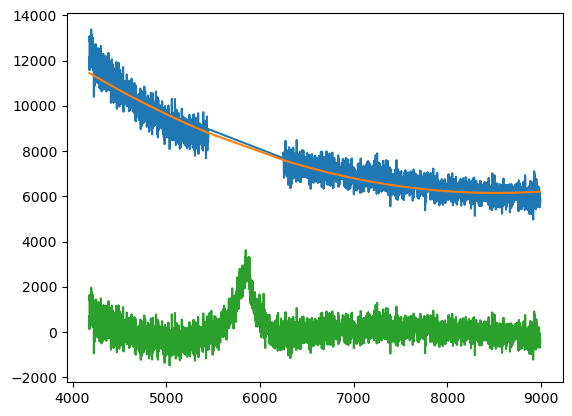

In [23]:
## testing new functions with just one

aft_res_reg = bg_reg2
bef_res_reg = bg_reg1

binstot = aft_res_reg[1]-bef_res_reg[0]  ## total number of bins in whole region
x1 = np.arange(bef_res_reg[0], bef_res_reg[1],1)
x2 = np.arange(aft_res_reg[0], aft_res_reg[1],1)
x = np.append(x1,x2)

fullx = np.arange(bef_res_reg[0], aft_res_reg[1],1) ## an array of every x bin in entire region
ys_bgsub = []

ys = all_D[0][0]

fitdata1 = ys[bef_res_reg[0]: bef_res_reg[1]]
fitdata2 = ys[aft_res_reg[0]: aft_res_reg[1]]
datasplice = np.append(fitdata1, fitdata2)
y = datasplice


# Fit model
coeffs = poly2_fit(x, y)
print("Fitted Coefficients:", coeffs)

# Predict
y_fit = poly2_predict(x, coeffs)

# Residuals (optional)
res = poly2_residuals(x, y, coeffs)
print("residuals:", res)

# data = odr.Data(x, y)
# poly_model2 = odr.polynomial(2)  # using third order polynomial model
# odr_obj = odr.ODR(data, poly_model2)
# output = odr_obj.run()  # running ODR fitting
# poly2 = np.poly1d(output.beta[::-1])
# poly_y2 = poly2(x)

fullpoly_y2 = poly2_predict(fullx, coeffs)


bgsubtracted = ys[bef_res_reg[0]:aft_res_reg[1]] - fullpoly_y2  ## subtracts RealData-BackgroundFit
ys_bgsub.append(bgsubtracted)
ys_bgsub[0] ## the array notation is left over from before...

plt.plot(x, y)
plt.plot(x, y_fit)
plt.plot(fullx, ys_bgsub[0])

In [12]:
### these both take a long time !!

bg_region1_beg = 4180
bg_region1_end = 5450
bg_region2_beg = 6250
bg_region2_end = 8992
bg_reg1 = [bg_region1_beg,bg_region1_end]
bg_reg2 = [bg_region2_beg,bg_region2_end]
fullrange = bg_reg2[1]-bg_reg1[0]

## change to 2nd order poly in cleaned up version
start = time.time()

def bg_fitsubtract_noseq(bef_res_reg, aft_res_reg, ys): ## before/after resonance region [start:end] respectively, ys[ch] to fit
    binstot = aft_res_reg[1]-bef_res_reg[0]  ## total number of bins in whole region
    x1 = np.arange(bef_res_reg[0], bef_res_reg[1],1)
    x2 = np.arange(aft_res_reg[0], aft_res_reg[1],1)
    x = np.append(x1,x2)
    fullx = np.arange(bef_res_reg[0], aft_res_reg[1],1) ## an array of every x bin in entire region
    ys_bgsub = []
    if len(ys)-1 >= 13:
        emessage = ('bg_ fit does not work for 6Li yet')
#         logger.error('run '+run_num + emessage)
        raise Exception(emessage)
    for ch in range(0,len(ys)-1):
        fitdata1 = ys[ch][bef_res_reg[0]: bef_res_reg[1]]
        fitdata2 = ys[ch][aft_res_reg[0]: aft_res_reg[1]]
        datasplice = np.append(fitdata1, fitdata2)
        y = datasplice
        data = odr.Data(x, y)
        poly_model2 = odr.polynomial(2)  # using third order polynomial model
        odr_obj = odr.ODR(data, poly_model2)
        output = odr_obj.run()  # running ODR fitting
        poly2 = np.poly1d(output.beta[::-1])
        poly_y2 = poly2(x)
        fullpoly_y2 = poly2(fullx)
        bgsubtracted = ys[ch][bef_res_reg[0]:aft_res_reg[1]] - fullpoly_y2  ## subtracts RealData-BackgroundFit
        ys_bgsub.append(bgsubtracted)
    return ys_bgsub ## the array notation is left over from before...

## background subtraction currently only for NaI detectors
num_fittingchs = numchannels-1  ## removes the Li detector, assumes it is there
bgsub_D = np.zeros((numruns_tot_D, num_fittingchs,fullrange), dtype = np.float64) ## num runs, channels, range of bg_ subtraction
bgsub_U = np.zeros((numruns_tot_U, num_fittingchs,fullrange), dtype = np.float64) ## num runs, channels, range of bg_ subtraction
times1 = []

for r in range(0, len(all_D)-600): ## for every run
    print(r)
    start = time.time()
#     if channels[ch] == 'ch_24':
#         emessage = ('bg_ fit does not work for 6Li yet')
#         logger.error('run '+run_num + emessage)
#         raise Exception(emessage)
#         print(r, ch)
#         print(channels[ch])
#         print(len(bgsub_D[r][ch]))
#         print(len(all_D[r][ch]))
    bgsub_D[r] = bg_fitsubtract_noseq(bg_reg1,bg_reg2, all_D[r])
    bgsub_U[r] = bg_fitsubtract_noseq(bg_reg1,bg_reg2, all_U[r])
    end = time.time()
    times1.append(end-start)
    print('run took '+str(end-start))

########################################################################## two attempts. both bad.
    
bg_region1_beg = 4180
bg_region1_end = 5450
bg_region2_beg = 6250
bg_region2_end = 8992
bg_reg1 = [bg_region1_beg,bg_region1_end]
bg_reg2 = [bg_region2_beg,bg_region2_end]
fullrange = bg_reg2[1]-bg_reg1[0]

## change to 2nd order poly in cleaned up version
start = time.time()

def bg_fitsubtract_noseq(bef_res_reg, aft_res_reg, ys): ## before/after resonance region [start:end] respectively, ys[ch] to fit
    binstot = aft_res_reg[1]-bef_res_reg[0]  ## total number of bins in whole region
    x1 = np.arange(bef_res_reg[0], bef_res_reg[1],1)
    x2 = np.arange(aft_res_reg[0], aft_res_reg[1],1)
    x = np.append(x1,x2)
    fullx = np.arange(bef_res_reg[0], aft_res_reg[1],1) ## an array of every x bin in entire region
    ys_bgsub = []
    fitdata1 = ys[bef_res_reg[0]: bef_res_reg[1]]
    fitdata2 = ys[aft_res_reg[0]: aft_res_reg[1]]
    datasplice = np.append(fitdata1, fitdata2)
    y = datasplice
    data = odr.Data(x, y)
    poly_model2 = odr.polynomial(2)  # using third order polynomial model
    odr_obj = odr.ODR(data, poly_model2)
    output = odr_obj.run()  # running ODR fitting
    poly2 = np.poly1d(output.beta[::-1])
    poly_y2 = poly2(x)
    fullpoly_y2 = poly2(fullx)
    bgsubtracted = ys[bef_res_reg[0]:aft_res_reg[1]] - fullpoly_y2  ## subtracts RealData-BackgroundFit
    ys_bgsub.append(bgsubtracted)
    return ys_bgsub[0] ## the array notation is left over from before...

## background subtraction currently only for NaI detectors
num_fittingchs = numchannels-1  ## removes the Li detector, assumes it is there
bgsub_D = np.zeros((numruns_tot_D, num_fittingchs,fullrange), dtype = np.float64) ## num runs, channels, range of bg_ subtraction
bgsub_U = np.zeros((numruns_tot_U, num_fittingchs,fullrange), dtype = np.float64) ## num runs, channels, range of bg_ subtraction
times2 = []

for r in range(0, len(all_D)-600): ## for every run
    print(r)
    start = time.time()
    for ch in range(0, num_fittingchs): ## and every channel (except 6Li)
        if channels[ch] == 'ch_24':
            emessage = ('bg_ fit does not work for 6Li yet')
            logger.error('run '+run_num + emessage)
            raise Exception(emessage)
#         print(r, ch)
#         print(channels[ch])
#         print(len(bgsub_D[r][ch]))
#         print(len(all_D[r][ch]))
        bgsub_D[r][ch] = bg_fitsubtract_noseq(bg_reg1,bg_reg2, all_D[r][ch])
        bgsub_U[r][ch] = bg_fitsubtract_noseq(bg_reg1,bg_reg2, all_U[r][ch])
    end = time.time()
    times2.append(end-start)
    print('run took '+str(end-start))

0
run took 6.200705051422119
1
run took 6.403738975524902
2
run took 6.116412162780762
3
run took 6.206817626953125
4
run took 6.945209741592407
5
run took 6.048011064529419
6
run took 5.800512075424194
7
run took 6.515385150909424
8
run took 6.8105669021606445
9
run took 6.4586341381073
10
run took 6.311155796051025
11
run took 5.996998310089111
12
run took 6.171201229095459
13
run took 6.385328769683838
14
run took 6.496899604797363
15
run took 6.669878005981445
16
run took 6.46414041519165
17
run took 6.148305654525757
18
run took 5.908167600631714
19
run took 6.143528938293457
20
run took 6.178879499435425
21
run took 6.235410690307617
22
run took 6.175605058670044
23
run took 6.174319505691528
24
run took 6.118877649307251
25
run took 6.224642992019653
26
run took 5.90382981300354
27
run took 6.631624698638916
28
run took 6.362154960632324
29
run took 6.313245058059692
30
run took 6.247541189193726
31
run took 6.083781957626343
32
run took 6.275695562362671
33
run took 6.300366640

In [18]:
r = 19
ch = 5

res_region_beg = bg_region1_end  ##currently res region is not selectable... inside of background region
res_region_end = bg_region2_beg
res_reg = [res_region_beg,res_region_end]
xdata = xs[bg_reg1[0]:bg_reg2[1]]
# xdata = xs[res_reg[0]:res_reg[1]]*1e-6

plt.plot(xs,run_ON_D[r][ch])
plt.plot(xdata, ON_bgsub[r][ch], lw = '1.0', label='trouble run')
plt.plot(xs,run_ON_D[r-1][ch])
plt.plot(xdata, ON_bgsub[r-1][ch], lw = '1.0', label='normal?')
plt.legend()
plt.show()

In [12]:

## change to 2nd order poly in cleaned up version
# start = time.time()

def bg_fitsubtract_np(bef_res_reg, aft_res_reg, ys): ## before/after resonance region [start:end] respectively, ys[ch] to fit
    binstot = aft_res_reg[1]-bef_res_reg[0]  ## total number of bins in whole region
    x1 = np.arange(bef_res_reg[0], bef_res_reg[1],1)
    x2 = np.arange(aft_res_reg[0], aft_res_reg[1],1)
    x = np.append(x1,x2)
    fullx = np.arange(bef_res_reg[0], aft_res_reg[1],1) ## an array of every x bin in entire region
#     ys_bgsub = []
    fitdata1 = ys[bef_res_reg[0]: bef_res_reg[1]]
    fitdata2 = ys[aft_res_reg[0]: aft_res_reg[1]]
    datasplice = np.append(fitdata1, fitdata2)
    y = datasplice
    
#     data = odr.Data(x, y)
#     poly_model2 = odr.polynomial(2)  # using third order polynomial model
#     odr_obj = odr.ODR(data, poly_model2)
#     output = odr_obj.run()  # running ODR fitting
#     poly2 = np.poly1d(output.beta[::-1])
#     poly_y2 = poly2(x)
#     fullpoly_y2 = poly2(fullx)
#     bgsubtracted = ys[bef_res_reg[0]:aft_res_reg[1]] - fullpoly_y2  ## subtracts RealData-BackgroundFit
    
    polyfit_param = np.polyfit(x,y,2)
    p = np.poly1d(polyfit_param)
    poly_y2_np = p(x)
    fullpoly_y2_np = p(fullx)
    bgsubtracted = ys[bef_res_reg[0]:aft_res_reg[1]] - fullpoly_y2_np 
#     ys_bgsub.append(bgsubtracted)
    return bgsubtracted

## background subtraction currently only for NaI detectors
num_fittingchs = len(run_ON_D[0])-1  ## removes the Li detector, assumes it is there
# numpoints = len(run_ON_D[0][0])
ON_bgsub_np = np.zeros((numruns,num_fittingchs,fullrange), dtype = np.float64) ## channels, sequences, range of bg_ subtraction
OFF_bgsub_np = np.zeros((numruns,num_fittingchs,fullrange), dtype = np.float64) ## channels, sequences, range of bg_ subtraction

# for r in range(0, 3):
for r in range(0, numruns):
    print('run '+str(r))
    for i in range(0, num_fittingchs):
#         print(i)
#         if channels[i] == 'ch_24':
#             emessage = ('bg_ fit does not work for 6Li yet')
#             logger.error('run '+run_num + emessage)
#             raise Exception(emessage)
        ON_bgsub_np[r][i]  = bg_fitsubtract_np(bg_reg1,bg_reg2, run_ON_D[r][i])
#         OFF_bgsub[r][i] = bg_fitsubtract(bg_reg1,bg_reg2, OFF_sums[r][i])

run 0
run 1
run 2
run 3
run 4
run 5
run 6
run 7
run 8
run 9
run 10
run 11
run 12
run 13
run 14
run 15
run 16
run 17
run 18
run 19
run 20
run 21
run 22
run 23
run 24
run 25
run 26
run 27
run 28
run 29
run 30
run 31
run 32
run 33
run 34
run 35
run 36
run 37
run 38
run 39
run 40
run 41
run 42
run 43
run 44
run 45
run 46
run 47
run 48
run 49
run 50
run 51
run 52
run 53
run 54
run 55
run 56
run 57
run 58
run 59
run 60
run 61
run 62
run 63
run 64
run 65
run 66
run 67
run 68
run 69
run 70
run 71
run 72
run 73
run 74
run 75
run 76
run 77
run 78
run 79
run 80
run 81
run 82
run 83
run 84
run 85
run 86
run 87
run 88
run 89
run 90
run 91
run 92
run 93
run 94
run 95
run 96
run 97
run 98
run 99
run 100
run 101
run 102
run 103
run 104
run 105
run 106
run 107
run 108
run 109
run 110
run 111
run 112
run 113
run 114
run 115
run 116
run 117
run 118
run 119
run 120
run 121
run 122
run 123
run 124
run 125
run 126
run 127
run 128
run 129
run 130
run 131
run 132
run 133
run 134
run 135
run 136
run 137
run 13

In [31]:
r = 45
ch = 8

res_region_beg = bg_region1_end  ##currently res region is not selectable... inside of background region
res_region_end = bg_region2_beg
res_reg = [res_region_beg,res_region_end]
xdata = xs[bg_reg1[0]:bg_reg2[1]]
# xdata = xs[res_reg[0]:res_reg[1]]*1e-6

plt.plot(xs,run_ON_D[r][ch])
# plt.plot(xdata, ON_bgsub[r][ch], lw = '1.0', label='trouble run')
plt.plot(xdata, ON_bgsub_np[r][ch], lw = '1.0', label='trouble run np version')
plt.plot(xs,run_ON_D[r-1][ch])
plt.plot(xdata, ON_bgsub[r-1][ch], lw = '1.0', label='normal?')
plt.axhline(y = 7430)
plt.axhline(y = 5448)
plt.axvline(x = 1.968)


plt.legend()
plt.show()

In [21]:
r = 19
ch = 5

binstot = bg_reg2[1]-bg_reg1[0]  ## total number of bins in whole region
x1 = np.arange(bg_reg1[0], bg_reg1[1],1)
x2 = np.arange(bg_reg2[0], bg_reg2[1],1)
x = np.append(x1,x2)
fullx = np.arange(bg_reg1[0], bg_reg2[1],1) ## an array of every x bin in entire region
#     ys_bgsub = []
fitdata1 = run_ON_D[r][ch][bg_reg1[0]: bg_reg1[1]]
fitdata2 = run_ON_D[r][ch][bg_reg2[0]: bg_reg2[1]]
datasplice = np.append(fitdata1, fitdata2)
y = datasplice

test = np.polyfit(x,y,2)
print(test)
p = np.poly1d(test)

# data = odr.Data(x, y)
# poly_model2 = odr.polynomial(2)  # using third order polynomial model
# odr_obj = odr.ODR(data, poly_model2)
# output = odr_obj.run()  # running ODR fitting
# poly2 = np.poly1d(output.beta[::-1])
poly_y2_np = p(x)
fullpoly_y2_np = p(fullx)
bgsubtracted = run_ON_D[r][ch][bg_reg1[0]:bg_reg2[1]] - fullpoly_y2_np  ## subtracts RealData-BackgroundFit

[ 1.89915030e-04 -3.22980410e+00  1.73365733e+04]


In [22]:
res_region_beg = bg_region1_end  ##currently res region is not selectable... inside of background region
res_region_end = bg_region2_beg
res_reg = [res_region_beg,res_region_end]
xdata = xs[bg_reg1[0]:bg_reg2[1]]
# xdata = xs[res_reg[0]:res_reg[1]]*1e-6

plt.plot(xs,run_ON_D[r][ch])
plt.plot(xdata, bgsubtracted, lw = '1.0', label='trouble run')
plt.plot(xs,run_ON_D[r][ch])
plt.plot(xdata, ON_bgsub[r][ch], lw = '1.0', label='Old polyfit')
plt.plot(xs,run_ON_D[r-1][ch])
plt.plot(xdata, ON_bgsub[r-1][ch], lw = '1.0', label='normal?')
plt.legend()
plt.show()

### now voigt fitting

In [23]:
# now voigt

def voigt2(x, sig, gam, xshift, amp):
    fit = voigt_profile(x-xshift, sig, gam)*amp
    return fit

# res_region_beg = 5450
# res_region_end = 6250
res_region_beg = bg_region1_end  ##currently res region is not selectable... inside of background region
res_region_end = bg_region2_beg
res_reg = [res_region_beg,res_region_end]
if res_reg[0] < bg_reg1[1] or res_reg[1]>bg_reg2[0]:
    emessage = ('Declared Background region and Resonance region have overlapping fitting regions')
    logger.error('run '+run_num + emessage)
    raise Exception(emessage)

# xdata = xs[res_reg[0]:res_reg[1]]*1e-6  ## just change all xs to ms and one array
xdata = xs[res_reg[0]:res_reg[1]]  ## just change all xs to ms and one array

# In[22]:

# resonance region is assumed to be in between 2 background regions. Could maybe change this. 11.22.24
# start = time.time()
 
def voigt_fitting(bef_res_reg, aft_res_reg,xs,ys):
    fit_curves = []
    parameters = []
#     for ch in range(0, len(ys)): ## number of sequences, usually 13
    ydata = ys[bef_res_reg[1]-bef_res_reg[0]:aft_res_reg[0]-bef_res_reg[0]] 
    popt, pcov = curve_fit(voigt2, xs, ydata, bounds = ([0,0,0,-np.inf], [np.inf,np.inf,np.inf, np.inf]))
#     popt, pcov = curve_fit(voigt2, xs, ydata)
    fitted_curve = voigt2(xs, popt[0],popt[1],popt[2],popt[3],) ## sigma, gamma, xshift (res. center), amp. related thing
#     fit_curves.append(fitted_curve)
    fit_params = popt
    fit_errs = np.diagonal(pcov)
#     parameters.append([fit_params,fit_errs])
    return fitted_curve, [fit_params,fit_errs]

res_size = res_reg[1]-res_reg[0] 
ON_vfit = np.zeros((len(ON_bgsub),len(ON_bgsub[0]),res_size), dtype = np.float64) ## runs, channels, range of V_ subtraction
OFF_vfit = np.zeros((len(ON_bgsub),len(ON_bgsub[0]),res_size), dtype = np.float64)

ON_vfit_params = np.zeros((len(ON_bgsub),len(ON_bgsub[0]),2,4), dtype = np.float64) ## channels, sequences,[params, param_errs], [sigma, gamma, shift, amp thing]
OFF_vfit_params = np.zeros((len(ON_bgsub),len(ON_bgsub[0]),2,4), dtype = np.float64)

# for r in range(0, numruns): 
# #         if channels[i] == 'ch_24':
# #             emessage = ('bg_ fit does not work for 6Li yet')
# #             logger.error('run '+run_num + emessage)
# #             raise Exception(emessage)
# #         try:
#         ON_vfit[r], ON_vfit_params[r]  = voigt_fitting(bg_reg1,bg_reg2,xdata, ON_bgsub[r])
#         print(r)
# #             OFF_vfit[r][i], OFF_vfit_params[r][i] = voigt_fitting(bg_reg1,bg_reg2,xdata, OFF_bgsub[r][i])
# #         except Exception as e:
# #             logger.error('run '+run_num + ' failed during Voigt fitting')
# #             logger.exception(e)

for r in range(0, numruns): 
    print(r)
    for i in range(0, len(ON_bgsub[0])): 
#         if channels[i] == 'ch_24':
#             emessage = ('bg_ fit does not work for 6Li yet')
#             logger.error('run '+run_num + emessage)
#             raise Exception(emessage)
        try:
            ON_vfit[r][i], ON_vfit_params[r][i]  = voigt_fitting(bg_reg1,bg_reg2,xdata, ON_bgsub_np[r][i])
#             OFF_vfit[r][i], OFF_vfit_params[r][i] = voigt_fitting(bg_reg1,bg_reg2,xdata, OFF_bgsub[r][i])
        except:
            print('still testing this')
            print('run '+str(r)+' ch '+str(i))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
still testing this
run 45 ch 7
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
still testing this
run 128 ch 7
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
still testing this
run 227 ch 0
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253

#### for some reason run=79, ch=11 fails and run=19, ch =5 looks terrible. run=83, ch. 9

#### np version has its own trouble. Look at r = 45, ch = 7. r = 128, ch = 7.

In [24]:
r = 79
ch = 11
xdata = xs[res_reg[0]:res_reg[1]] 
ydata = ON_bgsub[r][ch][bg_reg1[1]-bg_reg1[0]:bg_reg2[0]-bg_reg1[0]]

plt.plot(xdata,ON_vfit[r][ch])
plt.plot(xdata,ydata)
print(ON_vfit_params[r][ch])

[[3.25169444e-02 2.54842367e-02 1.96793778e+00 3.58091374e+02]
 [8.09333616e-06 1.24033622e-05 6.32309609e-07 7.81354484e+01]]


In [91]:
print(len(ON_vfit))
print(len(ON_vfit[0]))
print(len(ON_vfit[0][0]))

330
12
800


In [176]:
## look at fitting manually

r = 45
ch = 7

res_region_beg = 5450
res_region_end = 6250
res_reg = [res_region_beg,res_region_end]
xdata = xs[res_reg[0]:res_reg[1]]
ydata = ON_bgsub[r][ch][bg_reg1[1]-bg_reg1[0]:bg_reg2[0]-bg_reg1[0]]
ydata_np = ON_bgsub_np[r][ch][bg_reg1[1]-bg_reg1[0]:bg_reg2[0]-bg_reg1[0]]

def voigt2(x, sig, gam, xshift, amp):
#     xshift=1.9678
    fit = voigt_profile(x-xshift, sig, gam)*amp
    return fit

# popt, pcov = curve_fit(voigt2, xdata, ydata)
# popt, pcov = curve_fit(voigt2, xdata, ydata, bounds = ([0,0,1.5,-np.inf], [np.inf,np.inf,2.0, np.inf]))
popt, pcov = curve_fit(voigt2, xdata, ydata, bounds = ([0,0,0,-np.inf], [np.inf,np.inf,np.inf, np.inf]))
popt_np, pcov_np = curve_fit(voigt2, xdata, ydata_np, bounds = ([0,0,0,-np.inf], [np.inf,np.inf,np.inf, np.inf]))

print(popt)
print(pcov)

fitted_curve = voigt2(xdata, popt[0],popt[1],popt[2],popt[3],)
fitted_curve_np = voigt2(xdata, popt_np[0],popt_np[1],popt_np[2],popt_np[3],)

print(max(fitted_curve))
print((popt[3])*np.sqrt(2*np.pi))
print((popt[3])/(np.sqrt(2*np.pi)*popt[0]))
print((popt[3])/(popt[0]))
print(sum(fitted_curve)*(popt[0]*np.sqrt(2*np.pi)))

RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

In [177]:
print(ydata[10:20])
plt.plot(xdata, fitted_curve, label = 'regular version')
plt.plot(xdata, fitted_curve_np, label = 'np version')

# plt.plot(xs, ON_bgsub[1][0])
plt.legend()
plt.plot(xdata,ydata)

[ -64.17848146 -167.73496416 -458.12599825  367.63461155  311.708419
 -208.39184397 -330.97554306 -349.31700928  -34.24701699 -199.09877572]


NameError: name 'fitted_curve_np' is not defined

In [218]:
## try setting things constant for trouble ones
r = 45
ch = 7

res_region_beg = 5450
res_region_end = 6250
res_reg = [res_region_beg,res_region_end]
xdata = xs[res_reg[0]:res_reg[1]]
ydata = ON_bgsub[r][ch][bg_reg1[1]-bg_reg1[0]:bg_reg2[0]-bg_reg1[0]]
# ydata = ON_bgsub_np[r][ch][bg_reg1[1]-bg_reg1[0]:bg_reg2[0]-bg_reg1[0]]

# sig = 
# gam = 
# xshift = 

def voigt3(x, amp):
#     xshift=1.9678
    ## ch 5:
#     s = 0.043253230
#     g = 0.006067
#     res_loc = 1.9698596
    ## ch 11:
#     s = 0.039110152
#     g = 0.012317655539375172
#     res_loc = 1.9617306244821926
    ## ch 9:
#     s = 0.042199785942949083
#     g = 0.0031533887758442643
#     res_loc = 1.962500989185792
    ## ch 7:
    s = 0.042522924601082
    g = 0.0056886589305687055
    res_loc = 1.9674671154674273
#     g = 0
    fit = voigt_profile(x-res_loc, s, g)*amp
    return fit

# popt, pcov = curve_fit(voigt2, xdata, ydata)
# popt, pcov = curve_fit(voigt2, xdata, ydata, bounds = ([0,0,1.5,-np.inf], [np.inf,np.inf,2.0, np.inf]))
popt, pcov = curve_fit(voigt3, xdata, ydata)

print(popt)
print(pcov)

fitted_curve = voigt3(xdata, popt[0],)

# print(max(fitted_curve))
# print((popt[3])*np.sqrt(2*np.pi))
# print((popt[3])/(np.sqrt(2*np.pi)*popt[0]))
# print((popt[3])/(popt[0]))
# print(sum(fitted_curve)*(popt[0]*np.sqrt(2*np.pi)))

print(ydata[10:20])
plt.plot(xdata, fitted_curve)
# plt.plot(xs, ON_bgsub[1][0])
plt.plot(xdata,ydata)

[160.4606207]
[[7.88684477]]
[ -64.17848146 -167.73496416 -458.12599825  367.63461155  311.708419
 -208.39184397 -330.97554306 -349.31700928  -34.24701699 -199.09877572]


In [ ]:
plt.plot(xdata, fitted_curve, label = 'regular version')
plt.plot(xdata, fitted_curve_np, label = 'np version')

# plt.plot(xs, ON_bgsub[1][0])
plt.legend()
plt.plot(xdata,ydata)

In [ ]:
## changing to the constants above seems to be working (except those with bad poly fitting before)

In [79]:
print(ON_vfit[83][9][10:20])
print(ON_vfit_params[83][9][0])
print(ON_vfit_params[83][9][0][2])

print(ON_vfit[83][10][10:20])
print(ON_vfit_params[83][10][0])
print(ON_vfit_params[83][10][0][2])


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0.]
0.0
[19.05119416 19.17295857 19.2960278  19.42042326 19.54616688 19.67328107
 19.80178877 19.93171347 20.06307918 20.19591052]
[3.95943782e-02 1.06396179e-02 1.96622946e+00 1.79617545e+02]
1.9662294640152356


In [ ]:
All_Li6_asyms = np.zeros((numpoints), dtype=float) ## num points
for r in range(len(ch_asyms_All[0])):
    All_Li6_asyms = All_Li6_asyms + ch_asyms_All[-1][r]
All_Li6_asyms = All_Li6_asyms/numruns
    
NaI_asyms = np.zeros((len(ch_asyms_All)-1, numpoints), dtype=float) ## num points
for i in range(24): ## 0-11, (24 is 6Li)
    for r in range(len(ch_asyms_All[0])):
        NaI_asyms[i] = NaI_asyms[i] + ch_asyms_All[i][r]
NaI_asyms = NaI_asyms/numruns
        
All_NaI_asyms = np.zeros((numpoints), dtype=float) ## num points
for i in range(24): ## 0-23, not 0-24 (24 is 6Li)
    for r in range(len(ch_asyms_All[0])):
        All_NaI_asyms = All_NaI_asyms + ch_asyms_All[i][r]
All_NaI_asyms = All_NaI_asyms/numruns

upstrm = np.zeros((numpoints), dtype=float) ## num points
for i in range(0,12): ## 0-23, not 0-24 (24 is 6Li)
    print(i)
    for r in range(len(ch_asyms_All[0])):
#         print(upstrm[0:10])
        upstrm = upstrm + ch_asyms_All[i][r]
upstrm = upstrm/numruns
print()
dnstrm = np.zeros((numpoints), dtype=float) ## num points
for i in range(12,24): ## 0-23, not 0-24 (24 is 6Li)
    print(i)
    for r in range(len(ch_asyms_All[0])):
        dnstrm = dnstrm + ch_asyms_All[i][r]
dnstrm = dnstrm/numruns
# Upstrm_NaI_asyms = np.zeros((len(arr_sizer[0])), dtype=float) ## num points
# for i in range(12): ## 0-11, (24 is 6Li)
#     for r in range(len(ch_asyms_All[0])):
#         Upstrm_NaI_asyms = Upstrm_NaI_asyms + ch_asyms_All[i][r]

# Dnstrm_NaI_asyms = np.zeros((len(arr_sizer[0])), dtype=float) ## num points

# for i in range(12,24): ## 12-23, not 12-24 (24 is 6Li)
# #     print( i )
#     Dnstrm_NaI_asyms = Dnstrm_NaI_asyms + ch_asyms_All[i]

print(len(All_NaI_asyms))
print(len(All_Li6_asyms))
print()

print(len(NaI_asyms))
print(len(NaI_asyms[0]))
# print(len(Upstrm_NaI_asyms))
# print(len(Dnstrm_NaI_asyms))


In [ ]:
All_Li6_asyms_bg = np.zeros((numpoints_bg), dtype=float) ## num points
for r in range(len(ch_asyms_bg_All[0])):
    All_Li6_asyms_bg = All_Li6_asyms_bg + ch_asyms_bg_All[-1][r]
All_Li6_asyms_bg = All_Li6_asyms_bg/numruns
    
NaI_asyms_bg = np.zeros((len(ch_asyms_bg_All)-1, numpoints_bg), dtype=float) ## num points
for i in range(24): ## 0-11, (24 is 6Li)
    for r in range(len(ch_asyms_bg_All[0])):
        NaI_asyms_bg[i] = NaI_asyms_bg[i] + ch_asyms_bg_All[i][r]
NaI_asyms_bg = NaI_asyms_bg/numruns
        
All_NaI_asyms_bg = np.zeros((numpoints_bg), dtype=float) ## num points
for i in range(24): ## 0-23, not 0-24 (24 is 6Li)
    for r in range(len(ch_asyms_bg_All[0])):
        All_NaI_asyms_bg = All_NaI_asyms_bg + ch_asyms_bg_All[i][r]
All_NaI_asyms_bg = All_NaI_asyms_bg/numruns

upstrm = np.zeros((numpoints_bg), dtype=float) ## num points
for i in range(0,12): ## 0-23, not 0-24 (24 is 6Li)
    print(i)
    for r in range(len(ch_asyms_bg_All[0])):
#         print(upstrm[0:10])
        upstrm = upstrm + ch_asyms_bg_All[i][r]
upstrm = upstrm/numruns
print()
dnstrm = np.zeros((numpoints_bg), dtype=float) ## num points
for i in range(12,24): ## 0-23, not 0-24 (24 is 6Li)
    print(i)
    for r in range(len(ch_asyms_bg_All[0])):
        dnstrm = dnstrm + ch_asyms_bg_All[i][r]
dnstrm = dnstrm/numruns
# Upstrm_NaI_asyms_bg = np.zeros((len(arr_sizer[0])), dtype=float) ## num points
# for i in range(12): ## 0-11, (24 is 6Li)
#     for r in range(len(ch_asyms_bg_All[0])):
#         Upstrm_NaI_asyms_bg = Upstrm_NaI_asyms_bg + ch_asyms_bg_All[i][r]

# Dnstrm_NaI_asyms_bg = np.zeros((len(arr_sizer[0])), dtype=float) ## num points

# for i in range(12,24): ## 12-23, not 12-24 (24 is 6Li)
# #     print( i )
#     Dnstrm_NaI_asyms_bg = Dnstrm_NaI_asyms_bg + ch_asyms_bg_All[i]

print(len(All_NaI_asyms_bg))
print(len(All_Li6_asyms_bg))
print()

print(len(NaI_asyms_bg))
print(len(NaI_asyms_bg[0]))
# print(len(Upstrm_NaI_asyms_bg))
# print(len(Dnstrm_NaI_asyms_bg))


In [ ]:
# print(numruns)
# # print(upstrm)
# print(len(ch_asyms_All[9]))
# print((ch_asyms_All[9]))
print(ch_asyms_All[9][7])

In [ ]:
print(len(run_asyms_U_noLi))
print(run_asyms_U_noLi[20,11,2000:2010])
print(run_asyms_U_noLi[20][11][2000:2010])

print(len(run_asyms_U_noLi[0:330,11,2000:2010]))
print(len(run_asyms_U_noLi[0:330][11][2000:2010]))

# print((run_asyms_U_noLi[0][5][4000:4010]*330))
print(np.average(run_asyms_U_noLi[0:380,11,7900]*330))
print(NaI_asyms[11][7900])

In [ ]:
m = 8
# a = All_Li6_asyms
a = All_NaI_asyms
b = a.reshape(-1, m).mean(axis=1)
c = xs_cut[0]
d = c.reshape(-1, m).mean(axis=1)
print(len(a))
print(len(b))
print(len(d))

def rebin(ys, xs, rebinfactor):
    outys = ys.reshape(-1, rebinfactor).mean(axis=1)
    outxs = xs.reshape(-1, rebinfactor).mean(axis=1)
    return outys, outxs

rebinf = 8
All_NaI_asyms_rebin8, xs_cut_rebin8 = rebin(All_NaI_asyms, xs_cut[0], rebinf)
All_Li6_asyms_rebin8, xs_cut_rebin8 = rebin(All_Li6_asyms, xs_cut[0], rebinf)

print(len(All_NaI_asyms_rebin8))
print(len(xs_cut_rebin8))

In [ ]:
print(ch_asyms_All[0][0])
print(ch_asyms_All[15][0])
print(run_asyms_U_noLi[0][0])
print(run_asyms_U_noLi[3][0])
print(run_asyms_D[0][0])
print(run_asyms_D[3][0])

print(numruns)
print(upstrm)
print(dnstrm)
print(All_NaI_asyms)

In [18]:
# legend = []
%matplotlib qt

# plt.plot(xs_uncut[0], NaI_asyms[1] , label='NaI D1')
# plt.plot(xs_cut[0], NaI_asyms[1] , label='NaI D1')
# plt.plot(xs_cut[0], All_NaI_asyms/(24), label='All NaI')
plt.plot(xs_cut[0], (All_NaI_asyms/(24)), label='All NaI, no rebinning: ')
# plt.plot(xs_cut[0], (upstrm/(12)), label='upstrm, no rebinning: ')
# plt.plot(xs_cut[0], (dnstrm/(12)), label='dnstrm, no rebinning: ')

# plt.plot(xs_cut[0], (All_Li6_asyms), label='Li6, no rebinning: ')
# plt.plot(xs_cut_rebin8, (All_NaI_asyms_rebin8/(24)), label='All NaI, rebinning: ' + str(rebinf))
# plt.plot(xs_cut_rebin8, (All_Li6_asyms_rebin8), label='Li6, rebinning: ' + str(rebinf))

# plt.plot(xs_uncut[0], NaI_asyms[7] , label='NaI D1')
# plt.plot(d, b/24, label='All NaI')

# plt.plot(xs_uncut[0], All_Li6_asyms , label='6Li')
# plt.plot(xs_cut, All_Li6_asyms/4275 , label='6Li')
# plt.plot(d, b, label='6Li')

    
plt.title(f'asym, {numruns} runs, (' + str(numruns*4/60) + ' hours)') 
plt.xlabel("time from trigger (ms)")
plt.ylabel('absolute')

plt.ylim(-0.5,0.5)
# plt.xlim(xs_cut[1800],xs_cut[-1])
# plt.xlim(xs_uncut[0][1800],xs_uncut[0][-1])

# plt.axvline(xs[0][baseL], ls = '--')
# plt.axvline(xs[0][baseR], ls = '--')
# plt.axvline(xs_cut[1][7800], ls = '--', c ='g')
plt.axvline(xs_cut[1][7500], ls = '--', c ='r')
plt.axvline(xs_cut[1][7200], ls = '--', c ='r')

#plt.axvline(xs[1][intgrR], ls = '--', c ='g')
#plt.axvline(xs[2][HeintgrL], ls = '--', c ='r')
#plt.axvline(xs[2][HeintgrR], ls = '--', c ='r')

plt.legend()
plt.show()

NameError: name 'xs_cut' is not defined

In [28]:
print(np.round(All_NaI_asyms))
print(len(All_NaI_asyms))
print(max(All_NaI_asyms))
print((All_NaI_asyms[1993:2010]/24))
testbin = All_NaI_asyms[1993:]
print(len(testbin))
print(max(testbin))
print(min(testbin))
testbin2 = testbin+(-min(testbin))

[ 37.  -2. 115. ...   0.  -0.  -0.]
8992
25999.565525264814
[-9.95044979e-04 -7.62900556e-05 -4.14109419e-05 -4.12743442e-05
 -4.12203063e-05 -4.11685699e-05 -4.09245156e-05 -4.03186987e-05
 -3.92749640e-05 -3.69528353e-05 -3.65772075e-05 -3.58732753e-05
 -3.43094229e-05 -3.38552945e-05 -3.29173043e-05 -3.36112304e-05
 -3.34357901e-05]
6999
0.05548575720817054
-0.2802082942145837


In [29]:
# legend = []
%matplotlib qt

plt.plot(xs_cut[0][1993:], testbin2, label='All NaI, no rebinning: ')

plt.title(f'asym, {numruns} runs, (' + str(numruns*4/60) + ' hours)') 
plt.xlabel("time from trigger (ms)")
plt.ylabel('absolute')

plt.ylim(-0.5,0.5)

plt.legend()
plt.show()

In [182]:
bins = len(testbin2)
hist, bin_edges = np.histogram(testbin2, bins=bins)
print(hist)
print(bin_edges)
print(hist[200:300])
print(max(hist))
print(len(hist))

[1 0 0 ... 0 0 1]
[0.00000000e+00 4.79631449e-05 9.59262899e-05 ... 3.35598125e-01
 3.35646088e-01 3.35694051e-01]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
26
6999


In [191]:
testend_beg = testbin[0]-testbin[0]
plt.bar(bin_edges[:-1], hist, width = max(hist)/len(hist))  ## this plots the previous histogram !!!
# plt.xlabel('nC')
# plt.title('end-beg region pulse integrals run ' + run_num)
plt.show() 

In [150]:
binnum = 7000
# np.histogram(All_NaI_asyms, bins = binnum, range = [0, 4000])
plt.hist(testbin, bins = binnum, range = [0, 0.05])


(array([1., 3., 2., ..., 0., 0., 0.]),
 array([0.00000000e+00, 7.14285714e-06, 1.42857143e-05, ...,
        4.99857143e-02, 4.99928571e-02, 5.00000000e-02]),
 <BarContainer object of 7000 artists>)